In [15]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import time


from scipy.stats import skew, kurtosis
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, train_test_split

import numpy as np
from random import sample

import matplotlib.pyplot as plt
import matplotlib.colors as pltc
import seaborn as sns
from collections import Counter

plt.style.use('ggplot')
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [16]:
def format_csv(filepath):
    '''
    Formats each CSV according to the problem definition.
    Parameters:
    ----------
    filepath : (str)
        The (relative or absolute) filepath to the CSV file to be imported.
    Returns:
    ----------
    df : (Pandas DataFrame)
        A data frame with an intuitively labeled target attribute. 
    '''
    columns = ['seq', 'x_acc', 'y_acc', 'z_acc', 'label']
    col_types = {'seq':int, 'x_acc':float, 'y_acc':float, 'z_acc':float,'label':object}

    df = pd.read_csv(filepath, names=columns, dtype=col_types)

    df.loc[df['label'] == '0', 'label'] = '7'

    label_dict = {'1': 'Working at Computer',
                  '2': 'Standing up, Walking & Going Up/Down Stairs',
                  '3': 'Standing',
                  '4': 'Walking',
                  '5': 'Going Up/Down Stairs',
                  '6': 'Walking & Talking w/ Someone',
                  '7': 'Talking while Standing'}
    
    for k, v in label_dict.items():
        
        mask = df['label'] == k

        df.loc[mask, 'label'] = v


    return df

In [17]:
def format_csv2(filepath):
    '''
    Formats each CSV according to the problem definition.
    Parameters:
    ----------
    filepath : (str)
        The (relative or absolute) filepath to the CSV file to be imported.
    Returns:
    ----------
    df : (Pandas DataFrame)
        A data frame with an intuitively labeled target attribute. 
    '''
    columns = ['seq', 'x_acc', 'y_acc', 'z_acc', 'label']
    col_types = {'seq':int, 'x_acc':float, 'y_acc':float, 'z_acc':float,'label':object}

    df = pd.read_csv(filepath, names=columns, dtype=col_types)

    df.loc[df['label'] == '0', 'label'] = '7'

#     label_dict = {'1': 'Working at Computer',
#                   '2': 'Standing up, Walking & Going Up/Down Stairs',
#                   '3': 'Standing',
#                   '4': 'Walking',
#                   '5': 'Going Up/Down Stairs',
#                   '6': 'Walking & Talking w/ Someone',
#                   '7': 'Talking while Standing'}
    
#     for k, v in label_dict.items():
        
#         mask = df['label'] == k

#         df.loc[mask, 'label'] = v


    return df

In [20]:
def aggregate_subjects(files=files, subject_names=subjects):
    '''
    Aggregates all files in files into one dataframe.
    Parameters:
    ----------
    files : (list/iterable)
        An iterable object that contains the relative or absolute filenames
        of the CSV files to be aggregated. Default is a list of 15 numerically
        labeled files in the ../data/ directory.
    subject_names : (list/iterable)
        An iterable object containing an identifier for each subject.
        Default = [str(i) for i in range(1, 16)].
    Returns:
    ----------
    total_data_set : (Pandas DataFrame)
        A vertically stacked data frame of all data in files.
    '''
    frames = []
    for i in range(len(files)):

        frame = format_csv(files[i])

        frame['subject'] = subject_names[i]

        frames.append(frame)

    total_data_set = pd.concat(frames)

    return total_data_set

In [21]:
def aggregate_subjects2(files=files, subject_names=subjects):
    '''
    Aggregates all files in files into one dataframe.
    Parameters:
    ----------
    files : (list/iterable)
        An iterable object that contains the relative or absolute filenames
        of the CSV files to be aggregated. Default is a list of 15 numerically
        labeled files in the ../data/ directory.
    subject_names : (list/iterable)
        An iterable object containing an identifier for each subject.
        Default = [str(i) for i in range(1, 16)].
    Returns:
    ----------
    total_data_set : (Pandas DataFrame)
        A vertically stacked data frame of all data in files.
    '''
    frames = []
    for i in range(len(files)):

        frame = format_csv2(files[i])

        frame['subject'] = subject_names[i]

        frames.append(frame)

    total_data_set = pd.concat(frames)

    return total_data_set

In [22]:
def standardize_df(df, cols_to_scale, cols_to_keep, col_dtype_dict):
    '''
    Standardizes the columns in cols_to_scale to have mean 0 and variance 1.
    Adds on additional columns in cols_to_keep to final output.
    Parameters:
    ----------
    df : (Pandas DataFrame)
        A data frame that contains all columns in the cols_to_scale and
        cols_to_keep lists.
    cols_to_scale : (list)
        A list of the column names that should be scaled.
    cols_to_keep : (list)
        A list of column names to keep that should not be scaled.
    col_dtype_dict : (dict)
        A dictionary whose keys are the names of df's columns and whose values
        are the dtypes those columns should be.
    Returns:
    ----------
    standard_df : (Pandas DataFrame)
        A data frame that contains the standardized columns in cols_to_scale
        and the columns in cols_to_keep (un-standardized).
    '''
    stand_X = ((df[cols_to_scale].values - df[cols_to_scale].values.mean(axis=0)) 
            / df[cols_to_scale].values.std(axis=0))

    X = np.hstack((stand_X, df[cols_to_keep].values.reshape(-1, len(cols_to_keep))))

    cols_to_scale.extend(cols_to_keep)

    standard_df = pd.DataFrame(X, columns=cols_to_scale)

    for col, dtype in col_dtype_dict.items():
        standard_df[col] = standard_df[col].astype(dtype)

    return standard_df

In [23]:
def create_lagged_features(df, columns, shift, row_time_steps,
                           remove_imputed_zeros=True, verbose=True):
    '''
    Creates shift lagged columns for each column specified in columns.
    Parameters:
    ----------
    df : (Pandas DataFrame)
        A data frame that contains the columns listed in columns.
    columns : (list)
        A list of strings that are the columns for which shifted variables
        should be created. len(columns) * shift = number of new columns created.
    shift : (int)
        The number of sequence steps that each instance should be able to
        "look back." len(columns) * shift = number of new columns created.
    row_time_steps : (int)
        The number of time steps between instances (i.e. if the time between
        instance 0 and instance 1 is 5 minutes, this should be 5).
    remove_imputed_zeros : (bool)
        Whether the observations that have zeros which are necessarily imputed
        during this process should be removed. Default = True. The total
        number of instances that will be removed = shift.
    verbose : (bool)
        Whether the number of observations that are removed should be printed.
    Returns:
    ----------
    out : (Pandas DataFrame)
        A copy of the data frame that was passed in with the lagged columns
        added.
    '''
    out = df.copy()
    for col in columns:

        feature_names = [f"{col}_T_minus_{row_time_steps*i}" for i in range(1, shift + 1)]
        base = out[col].copy().values
        for x, new_col in enumerate(feature_names):
            x += 1
            values = np.insert(base, np.repeat(0, x), np.repeat(0, x))
            out[new_col] = values[:-x]

    if remove_imputed_zeros:
        cols = [col for col in out.columns if f'T_minus_{shift}' in col]

        masks = []
        for col in cols:
            mask = out[col] != 0
            masks.append(mask)

        total_mask = np.logical_and.reduce(masks)
        out = out.loc[total_mask,:]

        if verbose:
            print(f'{df.shape[0]-out.shape[0]} observations removed from data set.')
    
    return out

def create_lagged_df(df, activity_col, subject_col, columns, shift,
                     row_time_steps=1, remove_imputed_zeros=True,
                     verbose=True):
    '''
    Splits df into subsets based on the different activities in activity_col
    and calls create_lagged_features() with columns as the columns from which
    lagged features should be created. Note that there will NOT be any overlap
    of activities when creating the lagged features.
    
    Parameters:
    ----------
    df : (Pandas DataFrame)
        A data frame that contains the columns listed in columns.
    activity_col : (str)
        The name of the column that will be used to stratify the activity in
        the data set.
    subject_col : (str)
        The name of the column that will be used to stratify the subjects in
        the data set.
    columns : (list)
        A list of strings that are the columns for which shifted variables
        should be created. len(columns) * shift = number of new columns created.
    shift : (int)
        The number of sequence steps that each instance should be able to
        "look back." len(columns) * shift = number of new columns created.
    row_time_steps : (int)
        The number of time steps between instances (i.e. if the time between
        instance 0 and instance 1 is 5 minutes, this should be 5). Default = 1.
    remove_imputed_zeros : (bool)
        Whether the observations that have zeros which are necessarily imputed
        during this process should be removed. Default = True. The total
        number of instances that will be removed = shift.
    verbose : (bool)
        Whether the number of observations that are removed should be printed.
    Returns:
    ----------
    out : (Pandas DataFrame)
        A copy of the data frame that was passed in with the lagged columns
        added.
    '''
    frames = []

    for subject in np.unique(df[subject_col]):
        for activity in np.unique(df[activity_col]):

            mask = df[subject_col] == subject
            mask1 = df[activity_col] == activity
            subset = df.loc[mask & mask1, :].copy()

            lagged_activity_df = create_lagged_features(subset,
                                                        columns,
                                                        shift,
                                                        row_time_steps,
                                                        remove_imputed_zeros,
                                                        verbose)

            if remove_imputed_zeros:
                # adding the activity column back on to the data frame,
                # ensuring the column "lines up" since the observations with
                # zeros were removed.
                lagged_activity_df[activity_col] = subset.loc[shift:, activity_col].copy()

            frames.append(lagged_activity_df)

    return pd.concat(frames)

Modelling functions
1.Random Forest
2. AdaBoost Classifier
3. GradientBoost Classifier
4. MLP

In [24]:
import gc
model_dict = {"Random Forest": 
                  {"ModelPipeline": Pipeline([
                       ('scaler', StandardScaler()),
                       ('model', RandomForestClassifier(n_estimators=500,
                                                        random_state=5,
                                                        n_jobs=-1,
                                                        verbose=1))
                       ])
                   },
#               "AdaBoost Classifier":
#                   {"ModelPipeline": Pipeline([
#                        ('scaler', StandardScaler()),
#                        ('model', AdaBoostClassifier(n_estimators=500,
#                                                     random_state=5))          
#                        ])
#                    },
              "XGBoost Classifier":
                  {"ModelPipeline": Pipeline([
                       ('scaler', StandardScaler()),
                       ('model', XGBClassifier(n_estimators=500,
                                                            random_state=5,
                                                            nthread=20)),
                       ])
                    },
              "Multinomial Logistic Regression":
                  {"ModelPipeline": Pipeline([
                       ('scaler', StandardScaler()),
                       ('model', LogisticRegression(multi_class="ovr",
                                                    solver='saga',
                                                    max_iter=500,
                                                    n_jobs=-1,
                                                    verbose=1)),
                       ])
                   }
#               "MLP":
#                   {"ModelPipeline": Pipeline([
#                        ('scaler', StandardScaler()),
#                        ('model', MLPClassifier(hidden_layer_sizes=(100, 100),
#                                                batch_size=500,
#                                                verbose=1))
                                 
#                        ])
#                    }
             }

def cross_validate_multiple_models(X, y, model_dict=model_dict, cv=8,
                                   verbose=True):
    '''
    Cross validates mutliple ModelPipeline's that are composed of a
    StandardScaler and a model.
    Parameters:
    ----------
    X : (2D numpy ndarray)
        A two dimensional array of data to which the model pipeline should be
        fit.
    y : (1D numpy ndarray)
        A vector of response values that line up with the data provided to the
        X parameter.
    model_dict : (dict)
        A dictionary of dictionaries. The key's of the dictionary should be
        the names of the model ('Random Forest', 'MLP', 'SVM', etc) and the
        values should be another dictionary. Within this subdictionary, there
        should be a key-value pair whose key is 'ModelPipeline' and whose value
        is a valid sklearn Pipeline() object.
    cv : (int)
        A integer specifying 'K' in K-Fold cross validation.
    verbose : (bool)
        The verbosity level.
    Returns:
    ----------
    model_dict : (dict)
        The same model dict, however there will be a new key-value pair in each
        model's subdictionary that contains an array of the CV scores. The key
        for this array is 'CV Scores'.
    '''
    for model_name, model_sub_dict in model_dict.items():

        if verbose:
            print(f"Time = {time.ctime()} | Cross validating a {model_name} on X and y")

        model_scores = cross_val_score(model_sub_dict['ModelPipeline'],
                                       X,
                                       y,
                                       cv=cv,
                                       scoring='accuracy',
                                       n_jobs=-1,
                                       verbose=int(verbose))

        model_sub_dict['CV Scores'] = model_scores
        gc.collect()
        if verbose:
            print(f"Time = {time.ctime()} | {model_name} Accuracy = {np.mean(model_scores)}")

    return model_dict

Plotting Functions

In [89]:
def subject_comparison_plot(df, variable, color, title):
    '''
    Stacks multiple line plots on top of one another in order to compare how
    different subjects "behave" across a given activity and dimension. Pass
    in a dataframe with only one activity.
    Parameters:
    ----------
    df : (Pandas DataFrame)
        A data frame that contains a numeric column named variable.
    variable : (str)
        The name of the numerical column to be plotted.
    color : (str)
        The color to for the line plot.
    title : (str)
        The title for the plot. 
    Returns:
    ----------
    None : (None)
        No object is returned; the image is shown.
    '''
    fig = plt.figure(figsize=(12, 20))

    subjects = df['subject'].unique()
    for x, subject in enumerate(subjects):

        array = df.loc[df['subject'] == subject, variable]

        plt.subplot(len(subjects), 1, x+1)
        plt.plot(array, c=color)
        #plt.yticks(y_tick_range)
        plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False, labelsize=20)
        plt.title(label=f'Participant {subject}', loc='center', fontsize=20)

    plt.suptitle(title, fontweight='bold', fontsize=22, y=1.025)
    plt.tight_layout()
    plt.savefig(variable+".png",dpi=300)
    plt.show()

def barplot(df, values_col, labels_col, x_label, y_label, title,
            long_x_names=False, filename=False):
    '''
    Create a barplot using the values in values_col to dictate the bar heights
    and the labels in labels_col to dictate the labels for those values.
    Parameters:
    ----------
    df : (Pandas DataFrame)
        A data frame that contains a numeric column that contains the values
        to be used for bar heights (named values_col) and a column to be
        used as labels for those values (named labels_col).
    values_col : (str)
        The name of the column in df to be used to dictate the bar heights.
        Must be numeric.
    labels_col : (str)
        The name of the column in df to be used for the labels of the bars.
    x_label : (str)
        A label for the x axis.
    y_label : (str)
        A label for the y axis.
    title : (str)
        A title for the plot.
    long_x_names : (bool)
        Indicates whether the labels (keys in dictionary) for the x axis
        are long enough to warrant rotating them. Default=False.
    filename : (str)
        The filename to which the figure should be saved. If None (default),
        plt.show() will be called and the image will be shown.
    Returns:
    ----------
    None : (None)
        No object is returned; the image is either shown or saved to filename.
    '''
    fig = plt.figure(figsize=(12, 9))

    palette = sns.color_palette('husl', df.shape[0])
    sns.barplot(x=df[labels_col],
                y=df[values_col],
                order=df[labels_col],
                palette=palette)

    # setting y-axis to percentage
    locs, _ = plt.yticks()
    plt.yticks(locs, labels=['{:,.2%}'.format(x) for x in locs])

    if long_x_names:
        plt.xticks(rotation=-30, ha='left')

    plt.xlabel(x_label, fontweight='bold', fontsize=12)
    plt.ylabel(y_label, fontweight='bold', fontsize=12)
    plt.title(title, fontweight='bold', fontsize=16, y=1.025)

    plt.tight_layout()

    if not filename:
        plt.show()
    elif filename:
        plt.savefig(filename)

Functions for comparing models using plots

In [26]:
def cv_error_comparison_plot(df, x_label, y_label, title, filename=None):
    '''
    Plots multiple violinplots on the same figure to compare the distribution
    of cross validation scores.
    Parameters:
    ----------
    df : (Pandas DataFrame)
        A data frame whose column names will be used as the labels for the
        various violinplots and whose columns are the array's of cross
        validation errors.
    x_label : (str)
        A label for the x axis.
    y_label : (str)
        A label for the y axis.
    title : (str)
        A title for the plot.
    filename : (str)
        The filename to which the figure should be saved. If None (default),
        plt.show() will be called and the image will be shown.
    Returns:
    ----------
    None : (None)
        No object is returned; the image is either shown or saved to filename.
    '''
    fig, ax = plt.subplots(figsize=(12, 9))

    df = df[df.mean(axis=0).sort_values(ascending=False).index]
    parts = ax.violinplot(df.T,
                          showmeans=True,
                          showmedians=False,
                          showextrema=False)

    color_sample = sns.color_palette('husl', len(df.columns))
    for x, pc in enumerate(parts['bodies']):
        pc.set_facecolor(color_sample[x])
        pc.set_edgecolor('black')
        pc.set_alpha(1)

    # setting y-axis to percentage
    full_perc_range = np.arange(0, 1.1, 0.1)
    plt.yticks(full_perc_range,
               labels=['{:,.2%}'.format(x) for x in full_perc_range])

    plt.xticks(range(1, len(df.columns)+1), labels=df.columns)

    plt.xlabel(x_label, fontweight='bold', fontsize=12)

    plt.xticks(rotation=-30, ha='left')

    plt.ylabel(y_label, fontweight='bold', fontsize=12)
    plt.suptitle(title, fontweight='bold', fontsize=16)

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)

    if not filename:
        plt.show()
    elif filename:
        plt.savefig(filename, dpi = 300, format='tiff')

In [27]:
os.getcwd()

'/home/debajeet'

Load all files and vertically stack them. 
At the end of each line, there was a zero. I changed it to activity '7' because these lines were followed by activities with labels '7'. As this is a time series data, I made this assumption.

In [32]:
data_dir = '/home/debajeet/OneDrive_1_12-13-2021/'
subjects = [str(i) for i in range(1, 16)]
files = [data_dir + subject + '.csv' for subject in subjects]
files = [file[0:] for file in files]
df = aggregate_subjects(files) 


In [29]:
df

,seq,x_acc,y_acc,z_acc,label,subject
0,0,1502.0,2215.0,2153.0,Working at Computer,1
1,1,1667.0,2072.0,2047.0,Working at Computer,1
2,2,1611.0,1957.0,1906.0,Working at Computer,1
3,3,1601.0,1939.0,1831.0,Working at Computer,1
4,4,1643.0,1965.0,1879.0,Working at Computer,1
...,...,...,...,...,...,...
103496,103500,2043.0,2539.0,1990.0,Talking while Standing,15
103497,103500,2036.0,2508.0,1976.0,Talking while Standing,15
103498,103500,2025.0,2520.0,1991.0,Talking while Standing,15
103499,103500,2009.0,2546.0,2007.0,Talking while Standing,15


In [30]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [31]:
df = reduce_mem_usage(df)

Memory usage after optimization is: 62.48 MB
Decreased by 39.3%


Total no. of rows and column names

In [16]:
df.count()

seq        1926896
x_acc      1926896
y_acc      1926896
z_acc      1926896
label      1926896
subject    1926896
dtype: int64

Find distribution of subjects
1. We want to ensure that not all the data is coming from one subject to be able to build a generalizable model.
2. For example if one of the subjects, say 9, contributed to 50% fo the data, we would have biased data. And the model could be overfit on this data making it pick up nauanced habits of one particular person.
3. For our data, this is not the case, nearly all subjects have nearly about the same amount of data. Subject 13 has the lowest contribution ~4%. The maximum percentage here is ~9% by class 9. This is not a great difference in subject wise distribution.

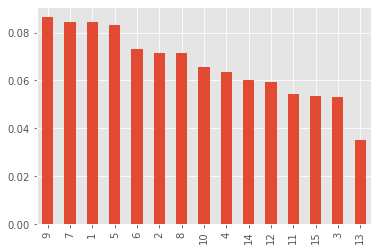

In [33]:
df['subject'].value_counts(normalize=True).plot.bar()

Find distribution of each class
1. The distribtion of data relative to activity type is skewed
2. We can observe that Working at Computer and Talking while Standing dominate the distribution. These two classes each contribute ~30% to the data.


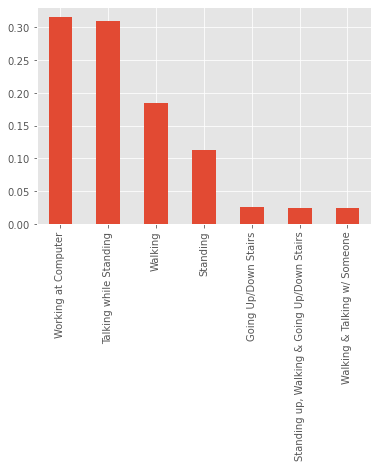

In [34]:
df['label'].value_counts(normalize=True).plot.bar()

Statistics for each column label pair, It should be noted that all the measurements are in m/s2

In [35]:
df.pivot_table(index=['label'], values=['x_acc','y_acc','z_acc'], aggfunc=[np.mean, np.std])


mean               \
                                                   x_acc        y_acc   
label                                                                   
Going Up/Down Stairs                         2000.554449  2385.493844   
Standing                                     1996.272755  2378.303095   
Standing up, Walking & Going Up/Down Stairs  1969.489431  2371.051965   
Talking while Standing                       1998.340516  2389.217249   
Walking                                      1976.819111  2386.292905   
Walking & Talking w/ Someone                 2027.107076  2374.075277   
Working at Computer                          1977.689653  2376.558532   

                                                                 std  \
                                                   z_acc       x_acc   
label                                                                  
Going Up/Down Stairs                         1997.001573  111.237068   
Standing                                     1965.729391  121.542182   
Standing up, Walking & Going Up/Down Stairs  1940.448703  110.537379   
Talking while Standing                       1973.384663  105.939770   
Walking                                      1978.708646  124.060266   
Walking & Talking w/ Someone                 1952.189366  121.550283   
Working at Computer                          1966.415593  101.580145   

                                                                     
                                                  y_acc       z_acc  
label                                                                
Going Up/Down Stairs                         107.876324   91.282547  
Standing                                      89.361650   70.465477  
Standing up, Walking & Going Up/Down Stairs   87.912346  108.297306  
Talking while Standing                        95.753926   63.859416  
Walking                                      114.916367   90.972573  
Walking & Talking w/ Someone                  87.496785   76.124904  
Working at Computer                           99.827210  123.734287

Normalize using standard normalization with mean = 0 and variance =1

In [36]:
dtype_dict = {'seq':object,
              'x_acc':float,
              'y_acc':float,
              'z_acc':float,
              'label':object,
              'subject':object}

# check src/format_data.py for aggregate_subjects() function
scaled_df = standardize_df(df, ['x_acc','y_acc','z_acc'], ['seq','label','subject'], dtype_dict)

In [37]:
scaled_df

,x_acc,y_acc,z_acc,seq,label,subject
0,-4.361188,-1.669967,1.931039,0,Working at Computer,1
1,-2.879478,-3.095476,0.808858,1,Working at Computer,1
2,-3.382361,-4.241864,-0.683854,2,Working at Computer,1
3,-3.472162,-4.421299,-1.477850,3,Working at Computer,1
4,-3.094999,-4.162115,-0.969693,4,Working at Computer,1
...,...,...,...,...,...,...
1926891,0.497027,1.559857,0.205421,103500,Talking while Standing,15
1926892,0.434167,1.250831,0.057209,103500,Talking while Standing,15
1926893,0.335386,1.370454,0.216008,103500,Talking while Standing,15
1926894,0.191705,1.629637,0.385394,103500,Talking while Standing,15


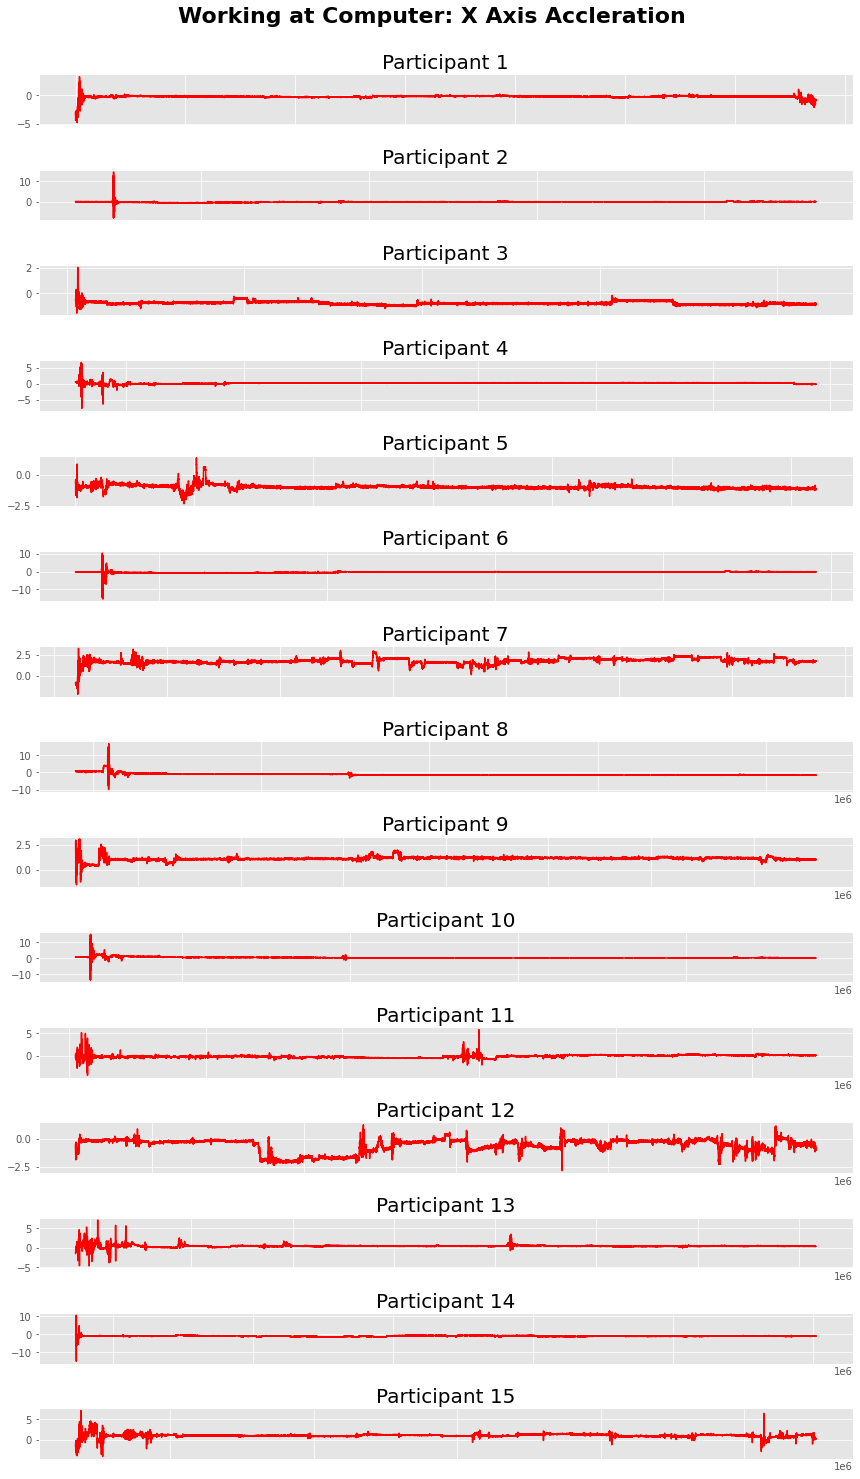

In [90]:
display_df = scaled_df[scaled_df['label'] == 'Working at Computer']
subject_comparison_plot(display_df, 'x_acc', 'red', 'Working at Computer: X Axis Accleration')

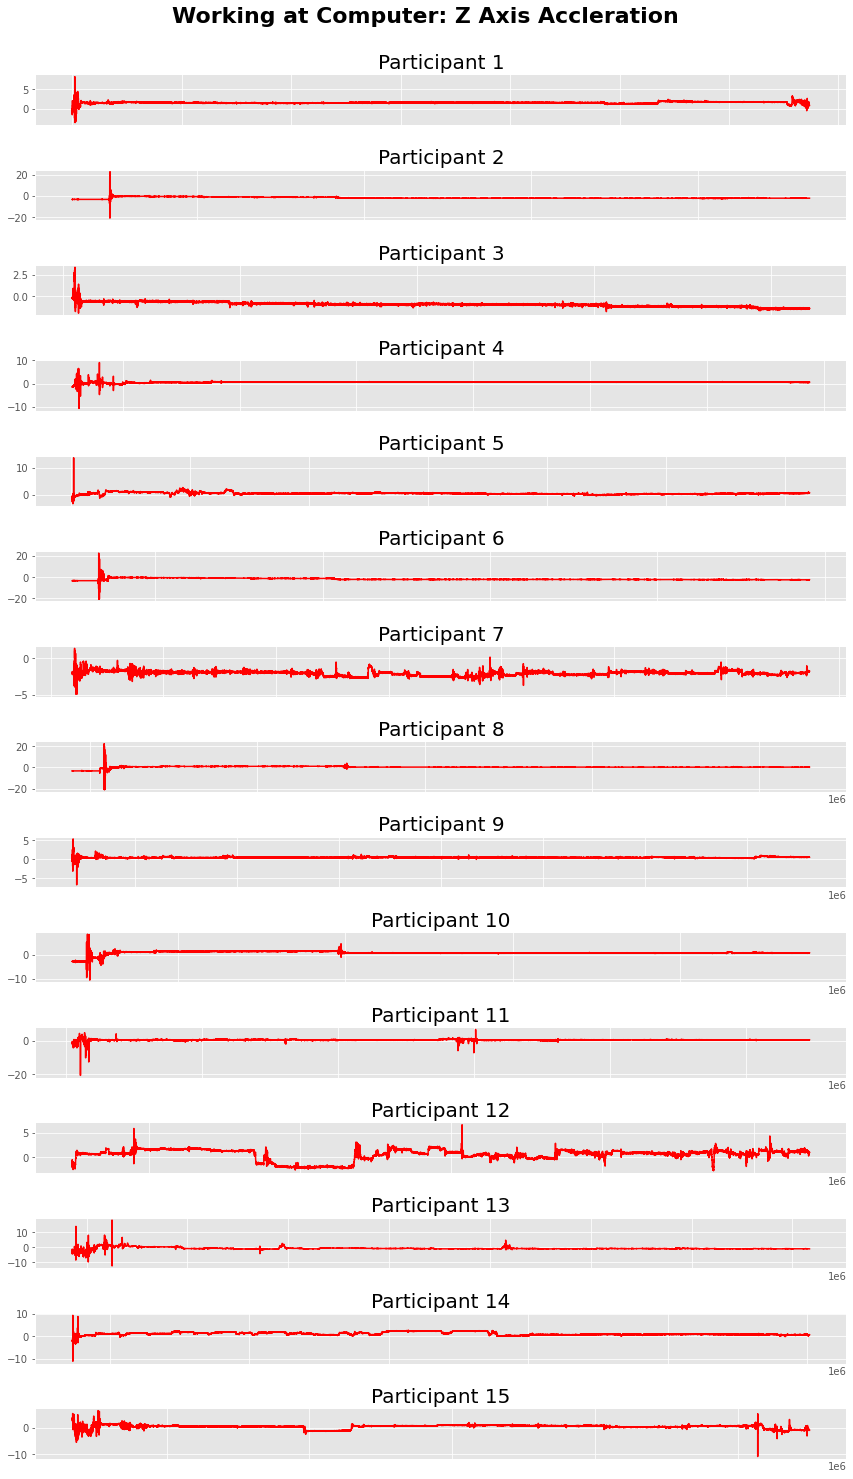

In [92]:
subject_comparison_plot(display_df, 'z_acc', 'red', 'Working at Computer: Z Axis Accleration')

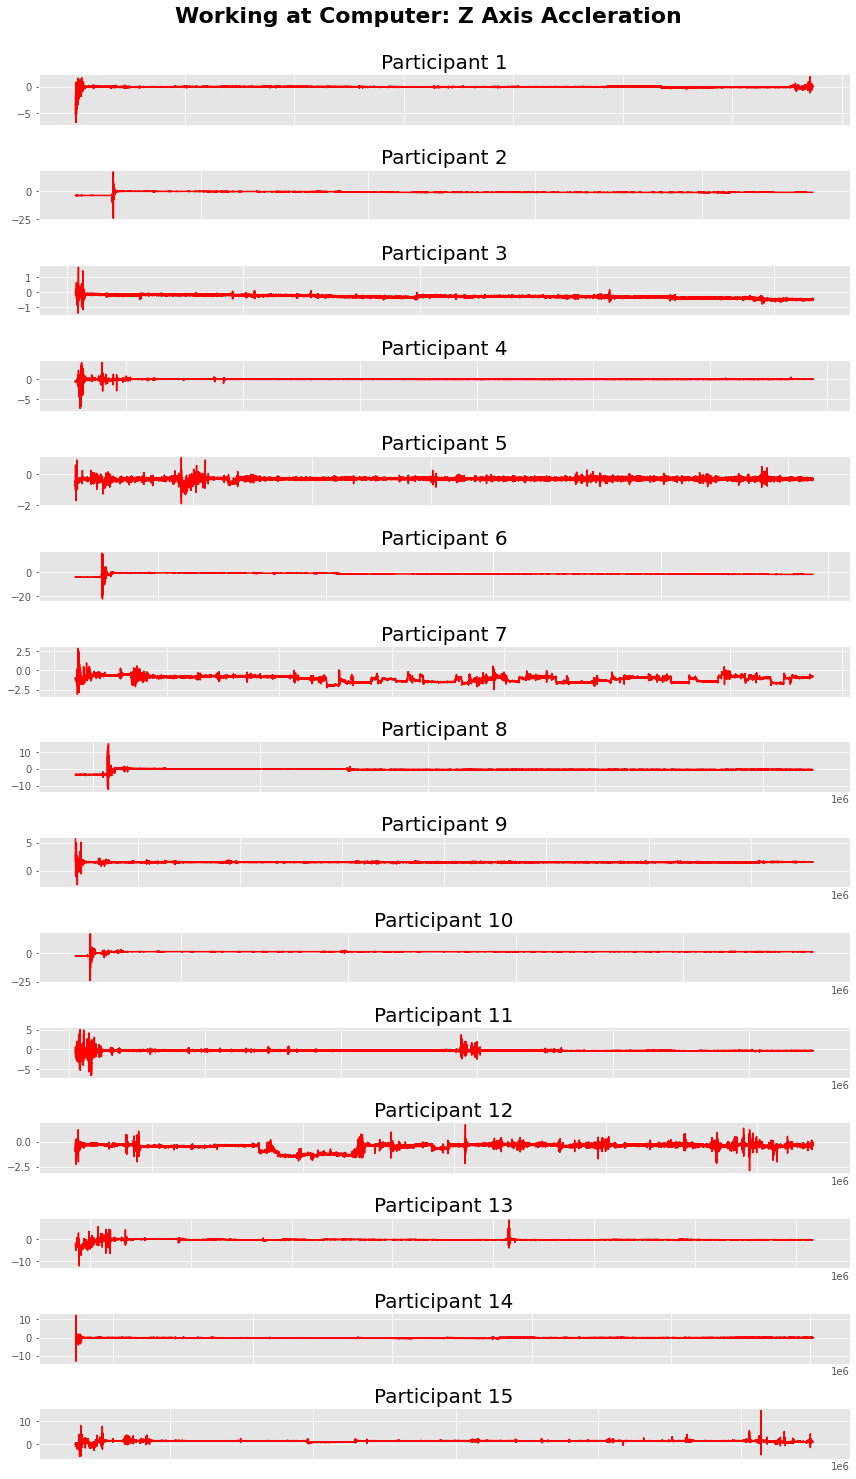

In [93]:
subject_comparison_plot(display_df, 'y_acc', 'red', 'Working at Computer: Z Axis Accleration')

In [83]:
#array = display_df.loc[display_df['subject'] == 2,'z_acc']
subjects = display_df['subject'].unique()
for x, subject in enumerate(subjects):

    array = display_df.loc[display_df['subject'] == subject, 'z_acc']
    print(len(array))

33677
44150
41675
31540
30980
44040
32750
44040
36090
44050
54170
48750
18280
52875
51600


Visualizing the scaled data gives us further insights to the data
We can infer that 
1. Going up and down the stairs has a high mean at the z component
2.Walking and talking with someone has a high x component

In [38]:
scaled_df.pivot_table(index=['label'], values=['x_acc','y_acc','z_acc'], aggfunc=[np.mean, np.std]).style.background_gradient(cmap="Blues")


In [32]:
ss = df['label'] == 'Working at Computer'
df_1 = df[ss]
audio = df_1['x_acc'][0:5040].values

In [ ]:
audio

Checking spectrograms for each activity

In [39]:
from librosa.core import stft
from librosa.display import specshow
from librosa.core import amplitude_to_db

ModuleNotFoundError: No module named 'librosa'

In [ ]:
def plot_spec(audio):
    x = audio
    fs = 52
    plt.specgram(x, NFFT=128, Fs=fs, noverlap=26)
    plt.colorbar()
    plt.xlabel("Time (seconds)")
    plt.ylabel("Frequency (Hz)")
    plt.show()
    


Spectrograms are a good way to identify uniques time-frequency characteristics that can be used for modeling later. For example, doppler effect of a plane passing by will look like a curve.

In [ ]:
for label in df['label'].unique():
    print(label)
    print('z_acc')
    ss = df['label'] == label
    df_1 = df[ss]
    audio = df_1['z_acc'][0:10040].values
    plot_spec(audio)

In [ ]:
for label in df['label'].unique():
    print(label)
    print('x_acc')
    ss = df['label'] == label
    df_1 = df[ss]
    audio = df_1['x_acc'][0:10040].values
    plot_spec(audio)

Spectrograms of y axis
1. Walking has repeating overtones in higher frequency bands
2. Going up and down the stairs has similar repeating overtones but aren't continuous temporally
3. Walking and talking also has repeating overtones but doesn't extend spatially

In [ ]:
for label in df['label'].unique():
    print(label)
    print('y_acc')
    ss = df['label'] == label
    df_1 = df[ss]
    audio = df_1['y_acc'][0:10040].values
    plot_spec(audio)

Feature generation
Since it's time series data, we should add sequential information to our features. We will do that by making use of lagged time series data. However, we should be careful about the model not picking up the order in which the subjects act. For example a person standing up, walking, going up or down sequentially. However, the model should be able to predict activities even if they don't occurr sequentially. Another case would be the model predicting the previous state as the present state, for example, a person sitting might continue sitting or person walking might continue walking.
1. Hence in our feature calculations we will not serve the model labels of previous states as categorical features.
2. We will only use lagged accelerometer readings for feature calculations

Here we create lagged dataframe for each subject activity pair, while removing rows where there are no missing lag values. 
We create lagged dataframe for each subject activity pair to prevent information from one class leaking to another while calculating features.

Under sample the data using Random under sampling.
It should be noted that features have already been calculated to take into account sequential information

In [13]:
data_dir = '/home/debajeet/OneDrive_1_12-13-2021/'
subjects = [str(i) for i in range(1, 16)]
files = [data_dir + subject + '.csv' for subject in subjects]
files = [file[0:] for file in files]
df = aggregate_subjects2(files) 

NameError: name 'aggregate_subjects2' is not defined

In [14]:
df

NameError: name 'df' is not defined

FFT and time series features
Rolling features are calculated at 5, 10 and 15 samples 
Remove columns label, subjects and seq to avoid data leakage

In [40]:
lag_15_df = create_lagged_df(df=df,
                             activity_col='label',
                             subject_col='subject',
                             columns=['x_acc','y_acc','z_acc'],
                             shift=15,
                             verbose=False)

# create 5, 10 & 15 minute rolling statistical features for each dimension
cols = list(lag_15_df.columns)
cols.remove('label')

for dimension in ['x','y','z']:
    for lag in [5, 10, 15]:

        # creating column subset for mean() & var() calculation
        input_cols = []
        for col in cols:
            if col in input_cols:
                continue
            # if dim in col and ...
            elif dimension in col:
                # if col != <dim>_acc col and the time lag of the col is <= lag
                #basically gets a lag of 5, 10 or 15, where let's say 5 values will produce x_acc_5_features
                #first condition checks if it is x_acc_minus1 and second lag checks if it is below a certain lag
                if len(col.split("_")) > 2 and int(col.split("_")[-1]) <= lag:
                    input_cols.append(col)
                # if the col == <dim>_acc col
                elif len(col.split("_")) == 2:
                    input_cols.append(col)
        dimension_cols = [col for col in cols if dimension in col]
        lag_15_df[f'rolling_T_minus_{lag}_{dimension}_average'] = np.mean(lag_15_df[input_cols], axis=1)
        lag_15_df[f'rolling_T_minus_{lag}_{dimension}_variance'] = np.var(lag_15_df[input_cols], axis=1)
        lag_15_df[f'rolling_T_minus_{lag}_{dimension}_min'] = np.min(lag_15_df[input_cols], axis=1)
        lag_15_df[f'rolling_T_minus_{lag}_{dimension}_max'] = np.max(lag_15_df[input_cols], axis=1)
        lag_15_df[f'rolling_T_minus_{lag}_{dimension}_kurtosis'] = kurtosis(lag_15_df[input_cols], axis=1)
        lag_15_df[f'rolling_T_minus_{lag}_{dimension}_skewness'] = skew(lag_15_df[input_cols], axis=1)
        zc = np.fft.fft(lag_15_df[dimension_cols], axis=1)
        realFFT = np.real(zc)
        imagFFT = np.imag(zc)
        lag_15_df[f'rolling_{dimension}_Rmean'] = realFFT.mean(axis=1)
        lag_15_df[f'rolling_{dimension}_Rstd'] = realFFT.std(axis=1)
        lag_15_df[f'rolling_{dimension}_Rmax'] = realFFT.max(axis=1)
        lag_15_df[f'rolling_{dimension}_Rmin'] = realFFT.min(axis=1)
# removing columns whose time lag isn't divisible by 5, a statistic column
# or one of the original variables given
cols_to_keep = ['x_acc','y_acc','z_acc', 'label']
for col in lag_15_df.columns[~lag_15_df.columns.isin(['seq','subject'])]:
    if col in cols_to_keep:
        continue
    elif 'roll' in col or 'var' in col:
        cols_to_keep.append(col)
    elif int(col.split("_")[-1]) % 5 == 0:
        cols_to_keep.append(col)

# removing columns that would lead to prediction leakage given the approach
X_columns = lag_15_df.columns[~lag_15_df.columns.isin(['label'])]
X_columns = lag_15_df.columns[~lag_15_df.columns.isin(['label','seq','subject'])]
lag_15_X = lag_15_df[X_columns].values
lag_15_y = lag_15_df['label'].values

# undersample majority classes randomly
under_sampler = RandomUnderSampler(sampling_strategy='not minority',
                                   random_state=5,
                                   replacement=False)

lag_15_X, lag_15_y = under_sampler.fit_resample(lag_15_X, lag_15_y)

# traditional train_test_split
x_train, x_test, y_train, y_test = train_test_split(lag_15_X,
                                                    lag_15_y,
                                                    test_size=0.25)

# model_dict originally defined in src/modeling.py
# Note that this will override the 'CV Scores' previously written when
# cross_validate_multiple_models was run with the lag_5_X data. Since the
# information is held within the cv_error_comparison_plot created, this
# isn't a problem.
# model_dict = cross_validate_multiple_models(x_train,
#                                             np.ravel(y_train))

# cv_error_dict = {}
# for name, sub_dict in model_dict.items():
#     cv_error_dict[name] = sub_dict['CV Scores']

# cv_error_comparison_plot(pd.DataFrame(cv_error_dict),
#                          x_label="Model Type",
#                          y_label="Accuracy",
#                          title='Approach 1: 8 Fold CV Accuracy with 15 Step Time Lag')

In [44]:
# lag_15_df.to_csv("fft_and_time_features.txt")

In [36]:
# rfc = RandomForestClassifier(n_estimators=600, max_depth=300, max_features='sqrt')
# rfc.fit(X_train,y_train)
# rfc_predict = rfc.predict(X_test)
# rfc_cv_score = cross_val_score(rfc, X, y, cv=10, scoring='roc_auc')

array([[38381, 2082.0, 2542.0, ..., 2009.0, -0.5229416737109043,
        0.4791106865635173],
       [20002, 2019.0, 2387.0, ..., 2039.0, -0.012715037103258275,
        -0.09190071614523027],
       [32835, 1979.0, 2274.0, ..., 1758.0, -0.4929401903468471,
        0.637413957171441],
       ...,
       [52998, 1963.0, 2383.0, ..., 1996.0, -1.0349497657577977,
        0.6038176456890634],
       [103530, 2050.0, 2379.0, ..., 2031.0, -0.7374209187024752,
        -0.6619555838270241],
       [155840, 2080.0, 2514.0, ..., 2070.0, 0.988504721015143,
        0.6970600908790711]], dtype=object)

In [25]:
X_columns

Index(['x_acc', 'y_acc', 'z_acc', 'x_acc_T_minus_1', 'x_acc_T_minus_2',
       'x_acc_T_minus_3', 'x_acc_T_minus_4', 'x_acc_T_minus_5',
       'x_acc_T_minus_6', 'x_acc_T_minus_7',
       ...
       'rolling_T_minus_10_z_min', 'rolling_T_minus_10_z_max',
       'rolling_T_minus_10_z_kurtosis', 'rolling_T_minus_10_z_skewness',
       'rolling_T_minus_15_z_average', 'rolling_T_minus_15_z_variance',
       'rolling_T_minus_15_z_min', 'rolling_T_minus_15_z_max',
       'rolling_T_minus_15_z_kurtosis', 'rolling_T_minus_15_z_skewness'],
      dtype='object', length=114)

In [ ]:
Train using Random forest model. Crossvalidate using 8 folds and traditional train and test split. Here all subjects
be either in train or test.

Time = Mon Jan  3 20:01:20 2022 | Cross validating a Random Forest on X and y


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:  4.2min remaining: 12.7min
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:  4.3min finished


Time = Mon Jan  3 20:05:37 2022 | Random Forest Accuracy = 0.8541009880571128
Time = Mon Jan  3 20:05:37 2022 | Cross validating a XGBoost Classifier on X and y


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed: 47.2min remaining: 141.6min
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed: 48.8min finished


Time = Mon Jan  3 20:54:27 2022 | XGBoost Classifier Accuracy = 0.8321107813698247
Time = Mon Jan  3 20:54:27 2022 | Cross validating a Multinomial Logistic Regression on X and y


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:  4.9min remaining: 14.8min
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:  5.3min finished


Time = Mon Jan  3 20:59:43 2022 | Multinomial Logistic Regression Accuracy = 0.35009273914615224


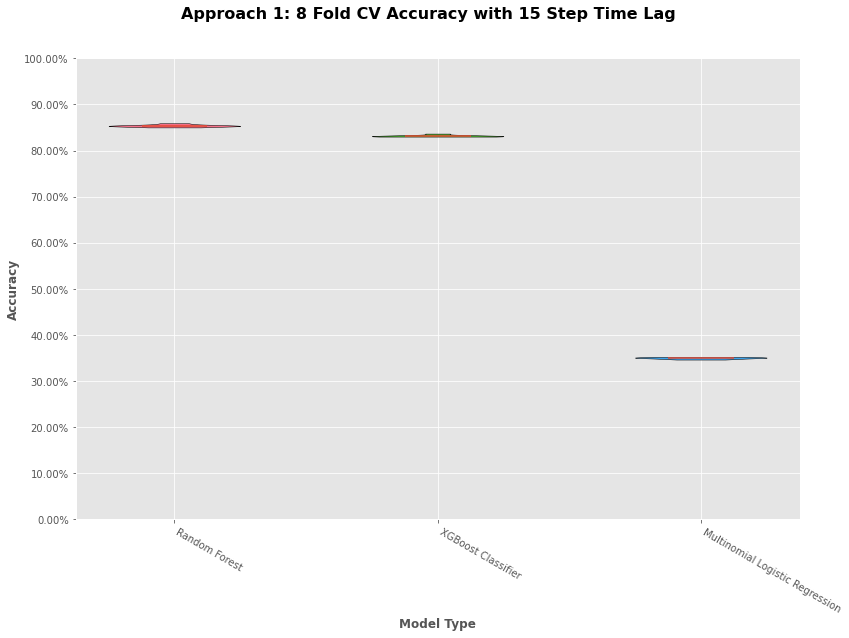

In [44]:
model_dict = cross_validate_multiple_models(x_train,
                                            np.ravel(y_train))

cv_error_dict = {}
for name, sub_dict in model_dict.items():
    cv_error_dict[name] = sub_dict['CV Scores']

cv_error_comparison_plot(pd.DataFrame(cv_error_dict),
                         x_label="Model Type",
                         y_label="Accuracy",
                         title='Approach 1: 8 Fold CV Accuracy with 15 Step Time Lag', filename='error_comp_plot.tiff')

In [ ]:
Cross-validation by training a model on each subject

Time = Wed Jan  5 11:09:33 2022 | Cross validating a Random Forest on X and y


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:   11.2s remaining:   33.7s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   11.3s finished


Time = Wed Jan  5 11:09:44 2022 | Random Forest Accuracy = 0.8251589454646634
Time = Wed Jan  5 11:09:44 2022 | Cross validating a XGBoost Classifier on X and y


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:   44.0s remaining:  2.2min
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   49.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.


Time = Wed Jan  5 11:10:34 2022 | XGBoost Classifier Accuracy = 0.8243266555370061
Time = Wed Jan  5 11:10:34 2022 | Cross validating a Multinomial Logistic Regression on X and y


[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:    4.7s remaining:   14.1s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    5.6s finished


Time = Wed Jan  5 11:10:39 2022 | Multinomial Logistic Regression Accuracy = 0.5887691291040623
Time = Wed Jan  5 11:10:41 2022 | Cross validating a Random Forest on X and y


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:   10.2s remaining:   30.7s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   10.4s finished


Time = Wed Jan  5 11:10:51 2022 | Random Forest Accuracy = 0.8840984024709297
Time = Wed Jan  5 11:10:51 2022 | Cross validating a XGBoost Classifier on X and y


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:  2.8min remaining:  8.4min
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:  3.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.


Time = Wed Jan  5 11:13:53 2022 | XGBoost Classifier Accuracy = 0.8975214032768402
Time = Wed Jan  5 11:13:53 2022 | Cross validating a Multinomial Logistic Regression on X and y


[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:   20.6s remaining:  1.0min
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   22.6s finished


Time = Wed Jan  5 11:14:16 2022 | Multinomial Logistic Regression Accuracy = 0.5575621106916142
Time = Wed Jan  5 11:14:17 2022 | Cross validating a Random Forest on X and y


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:    3.8s remaining:   11.3s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    3.9s finished


Time = Wed Jan  5 11:14:21 2022 | Random Forest Accuracy = 0.7665845030649793
Time = Wed Jan  5 11:14:21 2022 | Cross validating a XGBoost Classifier on X and y


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:   48.0s remaining:  2.4min


Time = Wed Jan  5 11:15:22 2022 | XGBoost Classifier Accuracy = 0.7697198074558717
Time = Wed Jan  5 11:15:22 2022 | Cross validating a Multinomial Logistic Regression on X and y


[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:  1.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:    6.8s remaining:   20.3s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    7.1s finished


Time = Wed Jan  5 11:15:29 2022 | Multinomial Logistic Regression Accuracy = 0.5092139446783184
Time = Wed Jan  5 11:15:30 2022 | Cross validating a Random Forest on X and y


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:    3.8s remaining:   11.3s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    3.9s finished


Time = Wed Jan  5 11:15:34 2022 | Random Forest Accuracy = 0.8157867746556693
Time = Wed Jan  5 11:15:34 2022 | Cross validating a XGBoost Classifier on X and y


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:  1.0min remaining:  3.1min
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:  1.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.


Time = Wed Jan  5 11:16:47 2022 | XGBoost Classifier Accuracy = 0.8243040598439055
Time = Wed Jan  5 11:16:47 2022 | Cross validating a Multinomial Logistic Regression on X and y


[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:    5.9s remaining:   17.8s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    6.5s finished


Time = Wed Jan  5 11:16:54 2022 | Multinomial Logistic Regression Accuracy = 0.5653366136977962
Time = Wed Jan  5 11:16:55 2022 | Cross validating a Random Forest on X and y


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:    3.7s remaining:   11.2s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    3.9s finished


Time = Wed Jan  5 11:16:59 2022 | Random Forest Accuracy = 0.8329583029459032
Time = Wed Jan  5 11:16:59 2022 | Cross validating a XGBoost Classifier on X and y


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:  1.1min remaining:  3.2min
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:  1.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.


Time = Wed Jan  5 11:18:09 2022 | XGBoost Classifier Accuracy = 0.829265405189568
Time = Wed Jan  5 11:18:09 2022 | Cross validating a Multinomial Logistic Regression on X and y


[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:    5.8s remaining:   17.5s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    6.6s finished


Time = Wed Jan  5 11:18:16 2022 | Multinomial Logistic Regression Accuracy = 0.6002242757341658
Time = Wed Jan  5 11:18:17 2022 | Cross validating a Random Forest on X and y


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:    2.7s remaining:    8.2s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    2.8s finished


Time = Wed Jan  5 11:18:20 2022 | Random Forest Accuracy = 0.8359201157098353
Time = Wed Jan  5 11:18:20 2022 | Cross validating a XGBoost Classifier on X and y


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:   20.5s remaining:  1.0min
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   23.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.


Time = Wed Jan  5 11:18:44 2022 | XGBoost Classifier Accuracy = 0.8429270428203788
Time = Wed Jan  5 11:18:44 2022 | Cross validating a Multinomial Logistic Regression on X and y


[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:    2.9s remaining:    8.7s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    3.2s finished


Time = Wed Jan  5 11:18:48 2022 | Multinomial Logistic Regression Accuracy = 0.6776970743600162
Time = Wed Jan  5 11:18:49 2022 | Cross validating a Random Forest on X and y


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:    3.3s remaining:   10.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    3.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.


Time = Wed Jan  5 11:18:53 2022 | Random Forest Accuracy = 0.7172697517956178
Time = Wed Jan  5 11:18:53 2022 | Cross validating a XGBoost Classifier on X and y


[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:   59.7s remaining:  3.0min
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:  1.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.


Time = Wed Jan  5 11:20:02 2022 | XGBoost Classifier Accuracy = 0.7176588421913954
Time = Wed Jan  5 11:20:02 2022 | Cross validating a Multinomial Logistic Regression on X and y


[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:    4.7s remaining:   14.1s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    5.1s finished


Time = Wed Jan  5 11:20:07 2022 | Multinomial Logistic Regression Accuracy = 0.48502166464893937
Time = Wed Jan  5 11:20:08 2022 | Cross validating a Random Forest on X and y


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:    9.6s remaining:   28.7s


Time = Wed Jan  5 11:20:19 2022 | Random Forest Accuracy = 0.8811604444034242
Time = Wed Jan  5 11:20:19 2022 | Cross validating a XGBoost Classifier on X and y


[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   10.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.
/home/debajeet/anaconda2/envs/seisml/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:  3.3min remaining: 10.0min
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:  3.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.


Time = Wed Jan  5 11:23:47 2022 | XGBoost Classifier Accuracy = 0.8914659236869025
Time = Wed Jan  5 11:23:47 2022 | Cross validating a Multinomial Logistic Regression on X and y


[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:   19.7s remaining:   59.2s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   22.2s finished


Time = Wed Jan  5 11:24:09 2022 | Multinomial Logistic Regression Accuracy = 0.521020520393487
Time = Wed Jan  5 11:24:10 2022 | Cross validating a Random Forest on X and y


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:    4.0s remaining:   11.9s


Time = Wed Jan  5 11:24:15 2022 | Random Forest Accuracy = 0.8701685421846148
Time = Wed Jan  5 11:24:15 2022 | Cross validating a XGBoost Classifier on X and y


[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    4.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:  1.1min remaining:  3.3min
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:  1.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.


Time = Wed Jan  5 11:25:27 2022 | XGBoost Classifier Accuracy = 0.8851590555531323
Time = Wed Jan  5 11:25:27 2022 | Cross validating a Multinomial Logistic Regression on X and y


[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:    7.5s remaining:   22.5s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    8.7s finished


Time = Wed Jan  5 11:25:36 2022 | Multinomial Logistic Regression Accuracy = 0.6582324394333707
Time = Wed Jan  5 11:25:37 2022 | Cross validating a Random Forest on X and y


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:    4.5s remaining:   13.5s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    5.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.


Time = Wed Jan  5 11:25:43 2022 | Random Forest Accuracy = 0.8453964387062728
Time = Wed Jan  5 11:25:43 2022 | Cross validating a XGBoost Classifier on X and y


[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:  1.6min remaining:  4.8min
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:  1.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.


Time = Wed Jan  5 11:27:25 2022 | XGBoost Classifier Accuracy = 0.8540415555406093
Time = Wed Jan  5 11:27:25 2022 | Cross validating a Multinomial Logistic Regression on X and y


[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:   10.3s remaining:   31.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   11.4s finished


Time = Wed Jan  5 11:27:37 2022 | Multinomial Logistic Regression Accuracy = 0.5381005819082036
Time = Wed Jan  5 11:27:38 2022 | Cross validating a Random Forest on X and y


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:    8.6s remaining:   25.8s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    8.8s finished


Time = Wed Jan  5 11:27:47 2022 | Random Forest Accuracy = 0.8888378465506125
Time = Wed Jan  5 11:27:47 2022 | Cross validating a XGBoost Classifier on X and y


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:  2.4min remaining:  7.1min
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:  2.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.


Time = Wed Jan  5 11:30:27 2022 | XGBoost Classifier Accuracy = 0.9128389508183741
Time = Wed Jan  5 11:30:27 2022 | Cross validating a Multinomial Logistic Regression on X and y


/home/debajeet/anaconda2/envs/seisml/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:   19.3s remaining:   57.9s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   20.5s finished


Time = Wed Jan  5 11:30:48 2022 | Multinomial Logistic Regression Accuracy = 0.6641845739025191
Time = Wed Jan  5 11:30:50 2022 | Cross validating a Random Forest on X and y


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:    9.8s remaining:   29.4s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   10.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.


Time = Wed Jan  5 11:31:01 2022 | Random Forest Accuracy = 0.874654540437507
Time = Wed Jan  5 11:31:01 2022 | Cross validating a XGBoost Classifier on X and y


[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:  3.1min remaining:  9.3min
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:  3.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.


Time = Wed Jan  5 11:34:23 2022 | XGBoost Classifier Accuracy = 0.886210605574321
Time = Wed Jan  5 11:34:23 2022 | Cross validating a Multinomial Logistic Regression on X and y


[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:   18.8s remaining:   56.3s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   20.4s finished


Time = Wed Jan  5 11:34:44 2022 | Multinomial Logistic Regression Accuracy = 0.565962766103181
Time = Wed Jan  5 11:34:45 2022 | Cross validating a Random Forest on X and y


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:    8.9s remaining:   26.6s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    9.0s finished


Time = Wed Jan  5 11:34:55 2022 | Random Forest Accuracy = 0.9038024971623155
Time = Wed Jan  5 11:34:55 2022 | Cross validating a XGBoost Classifier on X and y


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:  2.1min remaining:  6.2min


Time = Wed Jan  5 11:37:22 2022 | XGBoost Classifier Accuracy = 0.9158626560726446
Time = Wed Jan  5 11:37:22 2022 | Cross validating a Multinomial Logistic Regression on X and y


[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:  2.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:   18.1s remaining:   54.3s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   19.4s finished


Time = Wed Jan  5 11:37:42 2022 | Multinomial Logistic Regression Accuracy = 0.6894154370034052
Time = Wed Jan  5 11:37:43 2022 | Cross validating a Random Forest on X and y


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:    8.1s remaining:   24.4s


Time = Wed Jan  5 11:37:53 2022 | Random Forest Accuracy = 0.8638088137935449
Time = Wed Jan  5 11:37:53 2022 | Cross validating a XGBoost Classifier on X and y


[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   10.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:  3.2min remaining:  9.7min
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:  3.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.


Time = Wed Jan  5 11:41:17 2022 | XGBoost Classifier Accuracy = 0.8751170954882257
Time = Wed Jan  5 11:41:17 2022 | Cross validating a Multinomial Logistic Regression on X and y


[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:   18.6s remaining:   55.8s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   20.5s finished


Time = Wed Jan  5 11:41:38 2022 | Multinomial Logistic Regression Accuracy = 0.5690835667049546
Time = Wed Jan  5 11:41:39 2022 | Cross validating a Random Forest on X and y


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:    2.5s remaining:    7.5s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    2.5s finished


Time = Wed Jan  5 11:41:42 2022 | Random Forest Accuracy = 0.8063463930348259
Time = Wed Jan  5 11:41:42 2022 | Cross validating a XGBoost Classifier on X and y


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:   14.5s remaining:   43.4s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   16.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.


Time = Wed Jan  5 11:41:58 2022 | XGBoost Classifier Accuracy = 0.7944900497512438
Time = Wed Jan  5 11:41:58 2022 | Cross validating a Multinomial Logistic Regression on X and y


[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:    2.0s remaining:    5.9s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    2.2s finished


Time = Wed Jan  5 11:42:01 2022 | Multinomial Logistic Regression Accuracy = 0.566532960199005


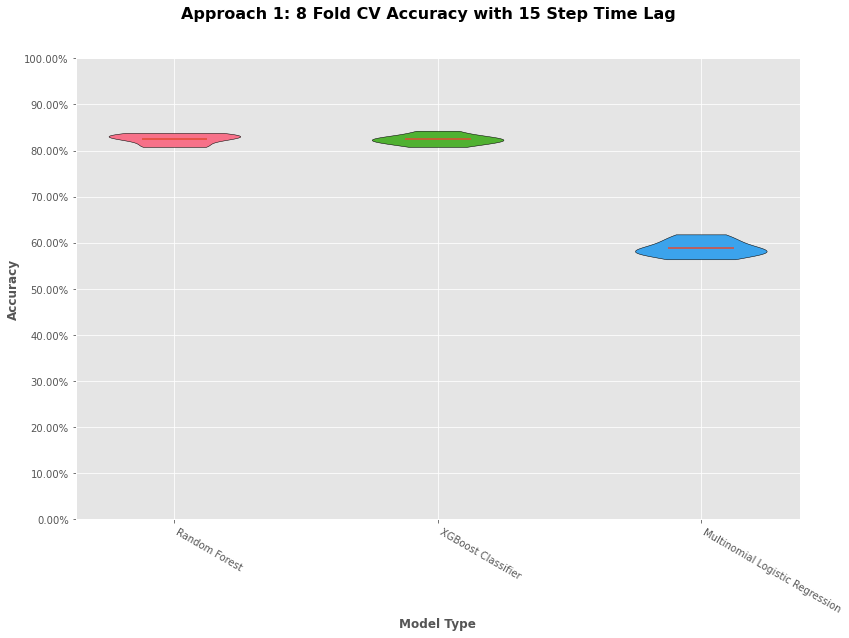

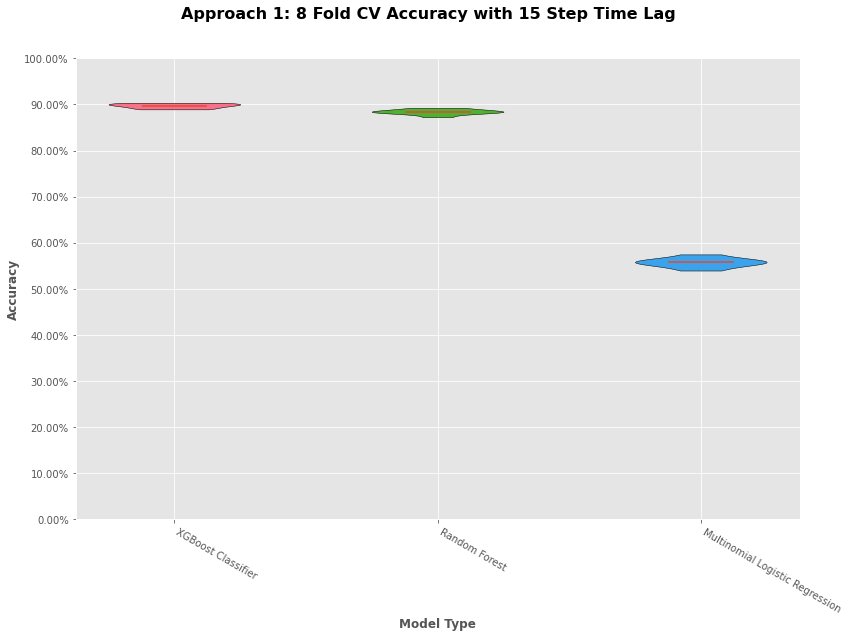

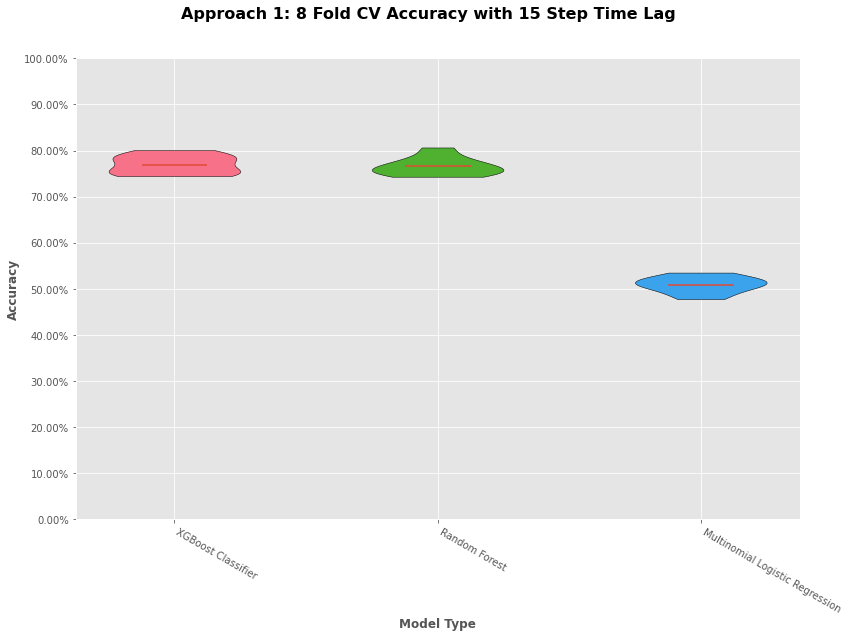

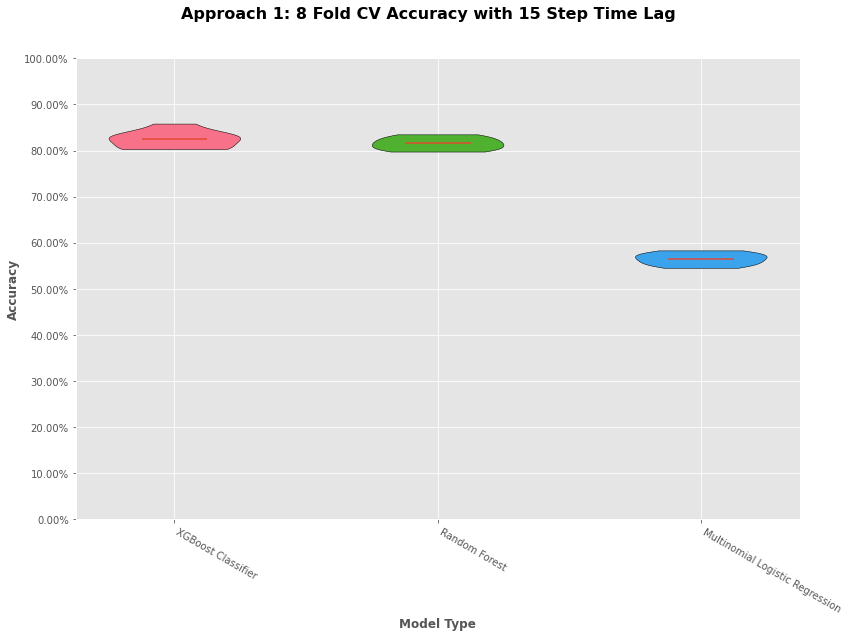

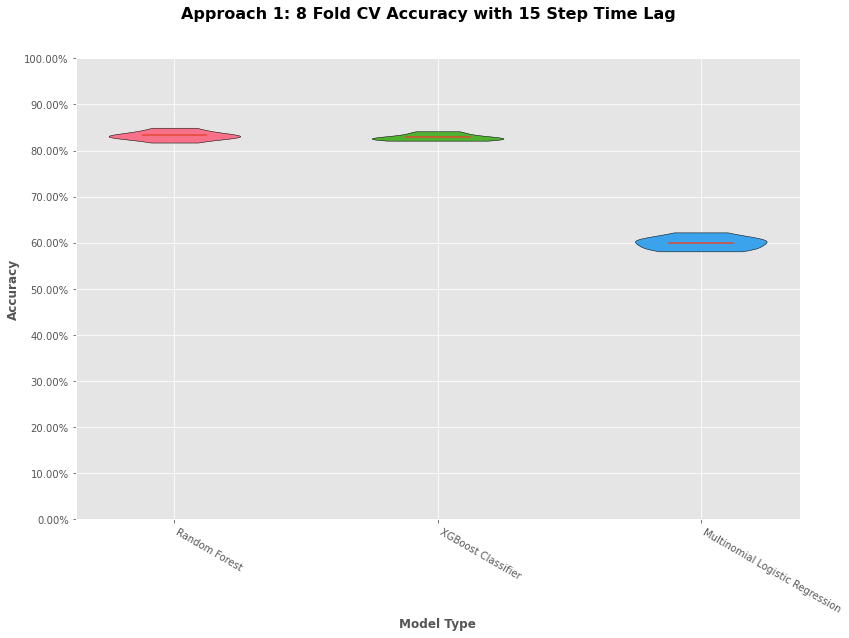

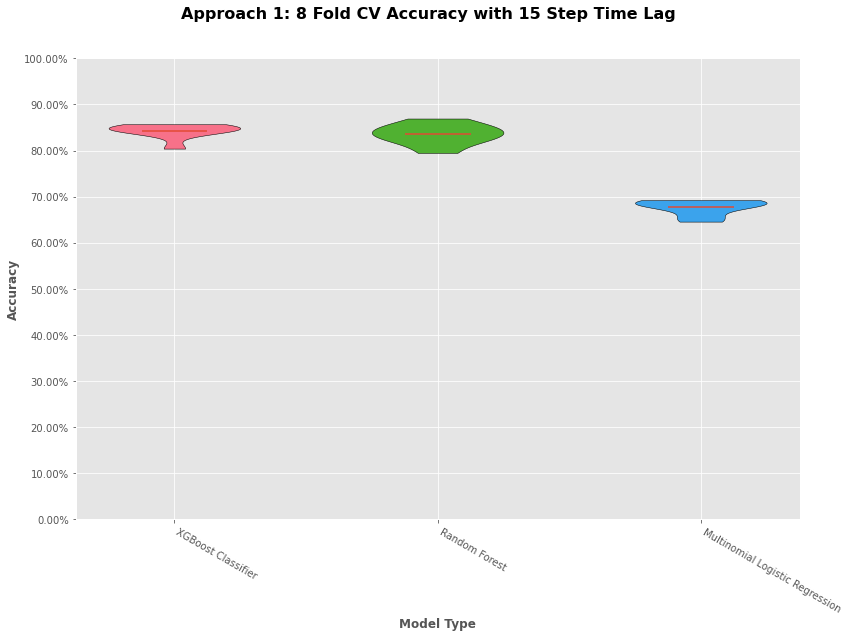

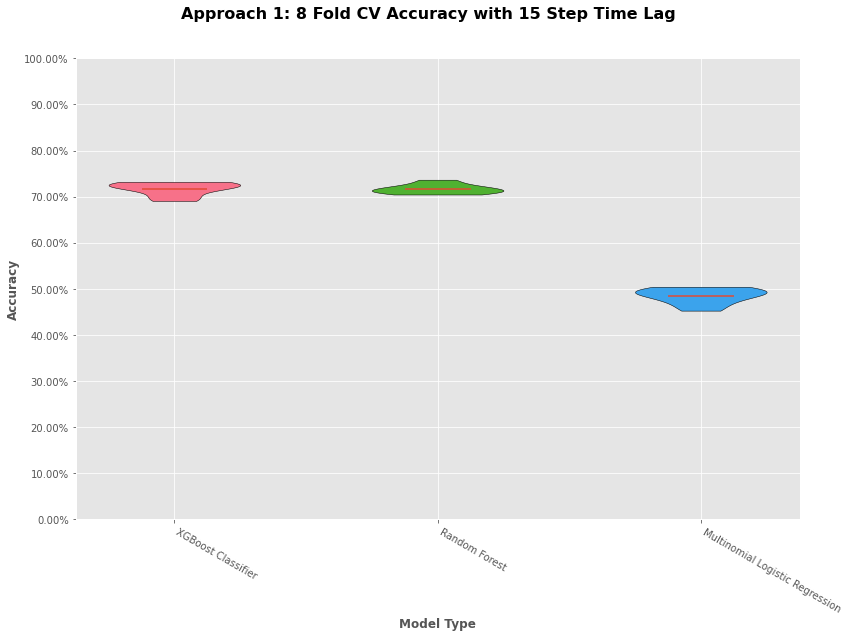

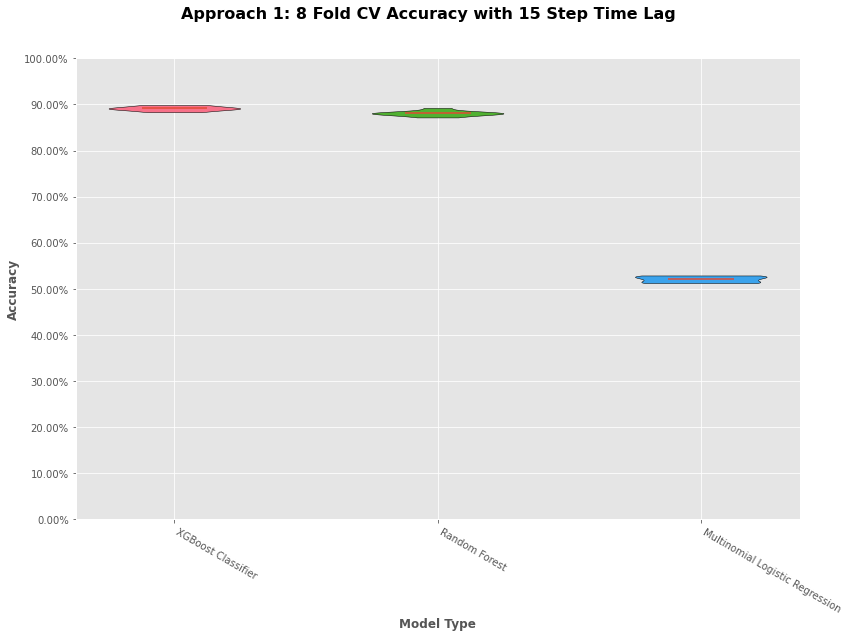

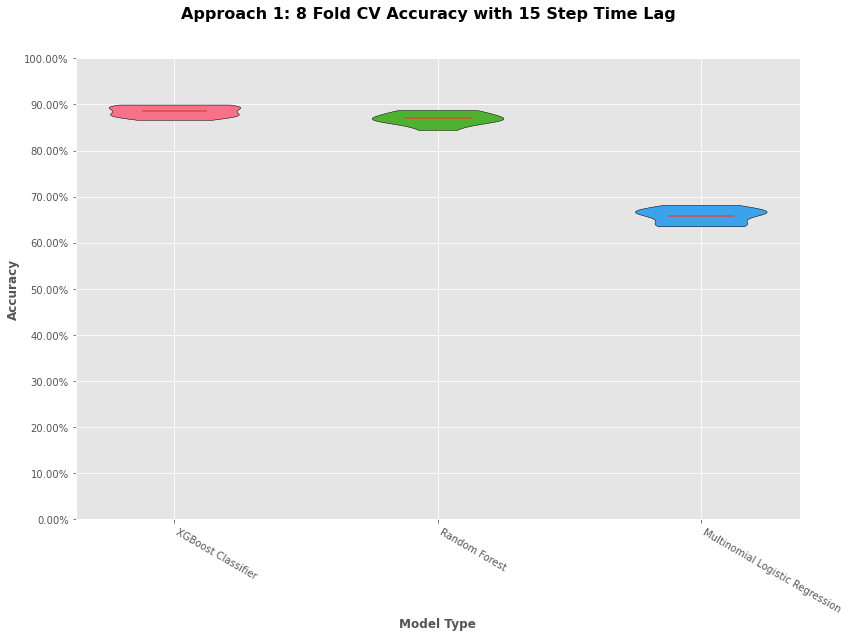

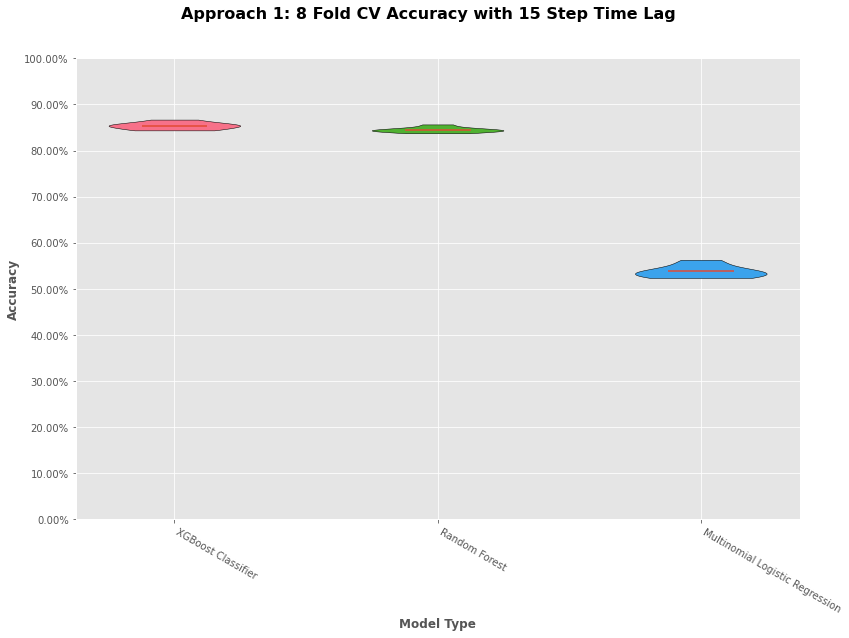

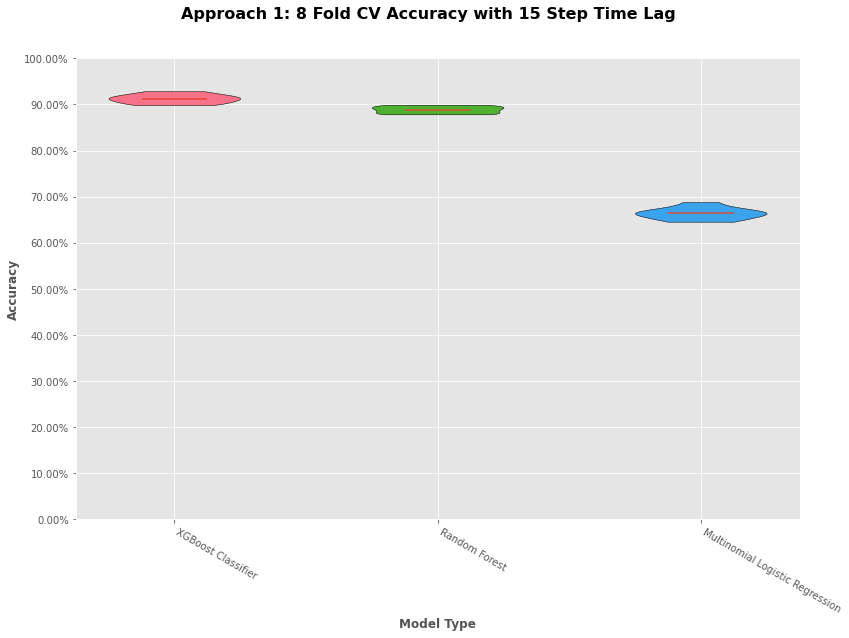

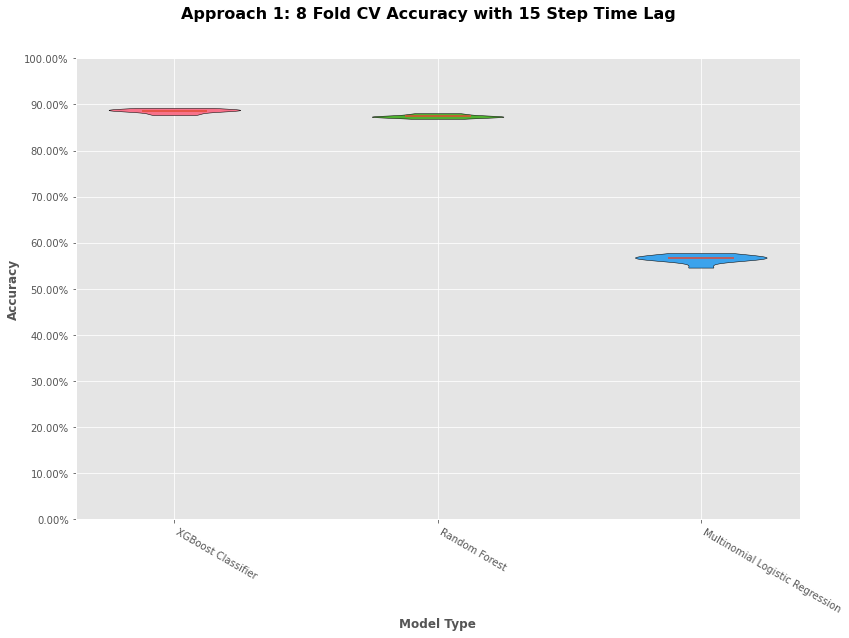

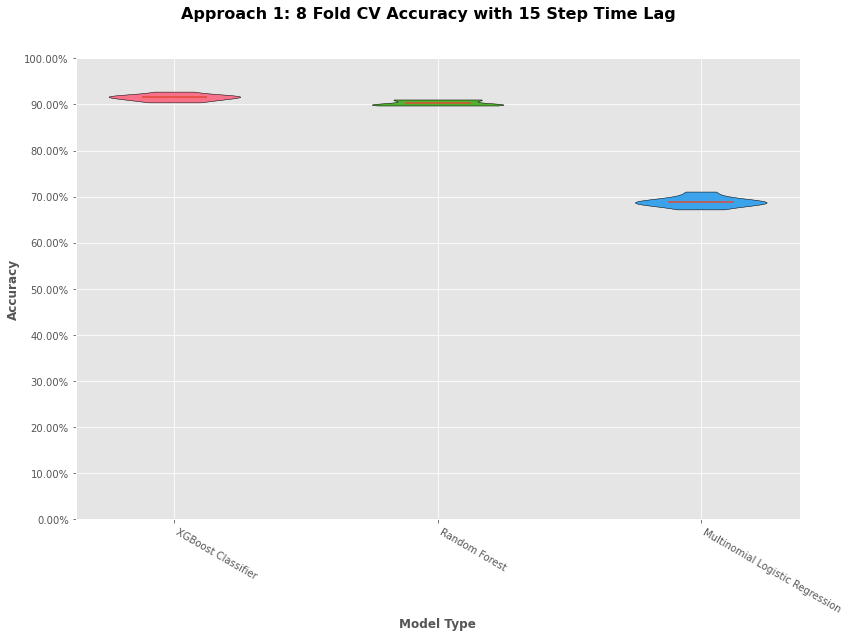

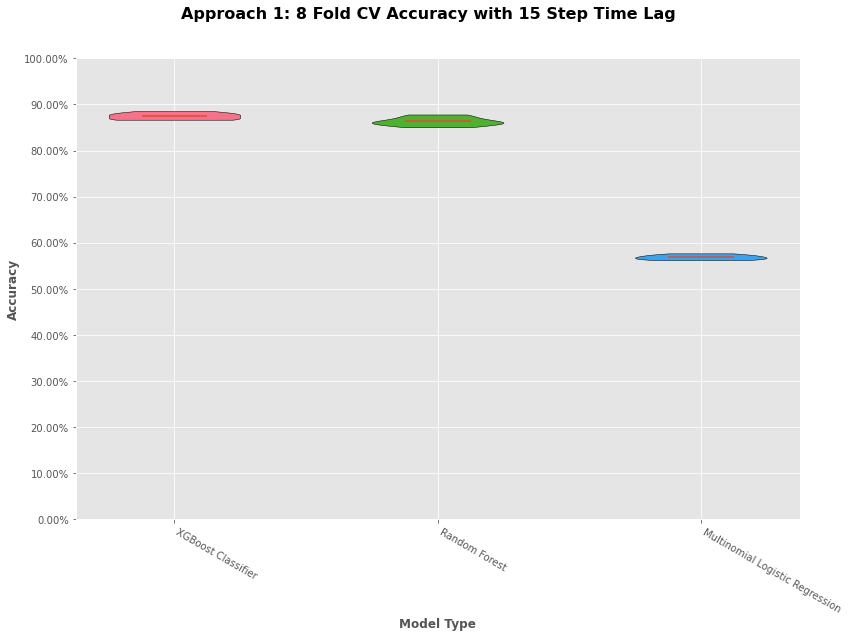

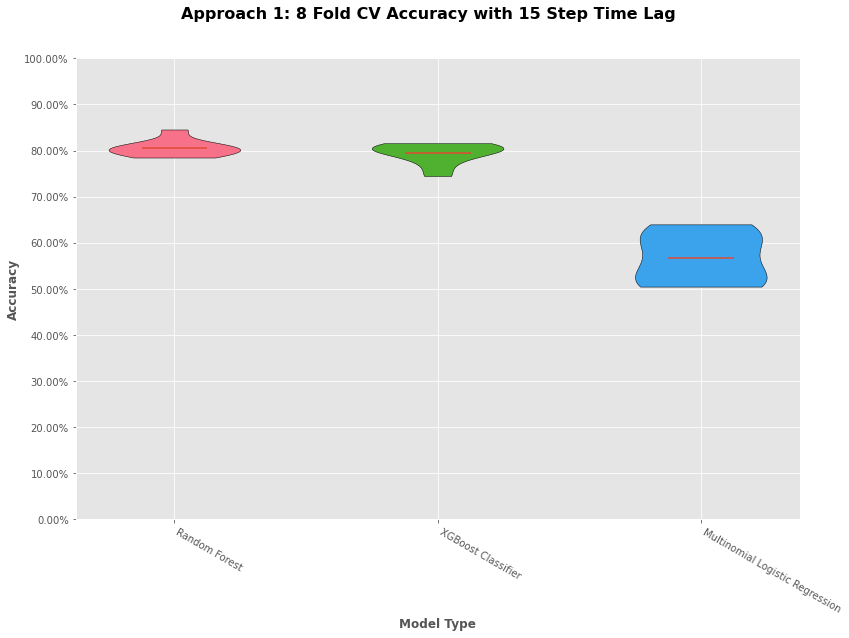

In [42]:
#training each model in model_dict on each subject

for subject in np.unique(lag_15_df['subject']):
    mask = lag_15_df['subject'] == subject
    lag_15_X = lag_15_df.loc[mask,X_columns].values
    lag_15_y = lag_15_df.loc[mask, 'label'].values
    
    #undersample majority classes randomly
    under_sampler = RandomUnderSampler(sampling_strategy='not minority', random_state = 5,
                                      replacement=False)
    lag_15_X, lag_15_y = under_sampler.fit_resample(lag_15_X, lag_15_y)

    # traditional train_test_split
    x_train, x_test, y_train, y_test = train_test_split(lag_15_X,
                                                        lag_15_y,
                                                        test_size=0.25)
    
    model_dict = cross_validate_multiple_models(x_train,
                                            np.ravel(y_train))

    cv_error_dict = {}
    for name, sub_dict in model_dict.items():
        cv_error_dict[name] = sub_dict['CV Scores']
    filename='error_comparison_personalized_' + str(subject) + '.tiff'
    cv_error_comparison_plot(pd.DataFrame(cv_error_dict),
                         x_label="Model Type",
                         y_label="Accuracy",
                         title='Approach 1: 8 Fold CV Accuracy with 15 Step Time Lag',filename=filename)
    
    

In [45]:
for subject in np.unique(lag_15_df['subject']):
    print(subject)

1
10
11
12
13
14
15
2
3
4
5
6
7
8
9


In [ ]:
# rfc = RandomForestClassifier(n_estimators=600, max_depth=300, max_features='sqrt')
# rfc.fit(X_train,y_train)
# rfc_predict = rfc.predict(X_test)
# rfc_cv_score = cross_val_score(rfc, X, y, cv=10, scoring='accuracy')

In [79]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# transform data
x_train_scaled = scaler.fit_transform(x_train)
print(x_train_scaled)
x_test_scaled = scaler.fit_transform(x_test)

[[-0.22937782 -0.02920596 -0.86207258 ... -0.96391531 -0.56941009
  -0.31521326]
 [ 0.52014282 -0.08178325 -0.73207557 ... -0.89455829 -0.86041646
   0.30956055]
 [-1.35365877 -0.90549418 -0.08209055 ...  1.68899076 -0.25308045
   1.78336268]
 ...
 [-0.04199766  0.07594863  0.61989327 ... -0.02759552 -1.12852959
  -0.42943997]
 [ 0.11415248  0.00584557 -0.47208156 ... -0.73850499  0.17959897
  -0.91588107]
 [ 0.05169242  0.18110321 -0.75807498 ... -0.75584424  2.5170255
  -2.50578531]]


In [80]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

rfc = RandomForestClassifier(n_estimators=500, random_state=5)
rfc.fit(x_train_scaled,y_train)
y_pred_test = rfc.predict(x_test_scaled)
# View accuracy score
accuracy_score(y_test, y_pred_test)
#rfc_cv_score = cross_val_score(rfc, X, y, cv=10, scoring='accuracy')

0.6760299625468165

Random forest predicted confusion matrix

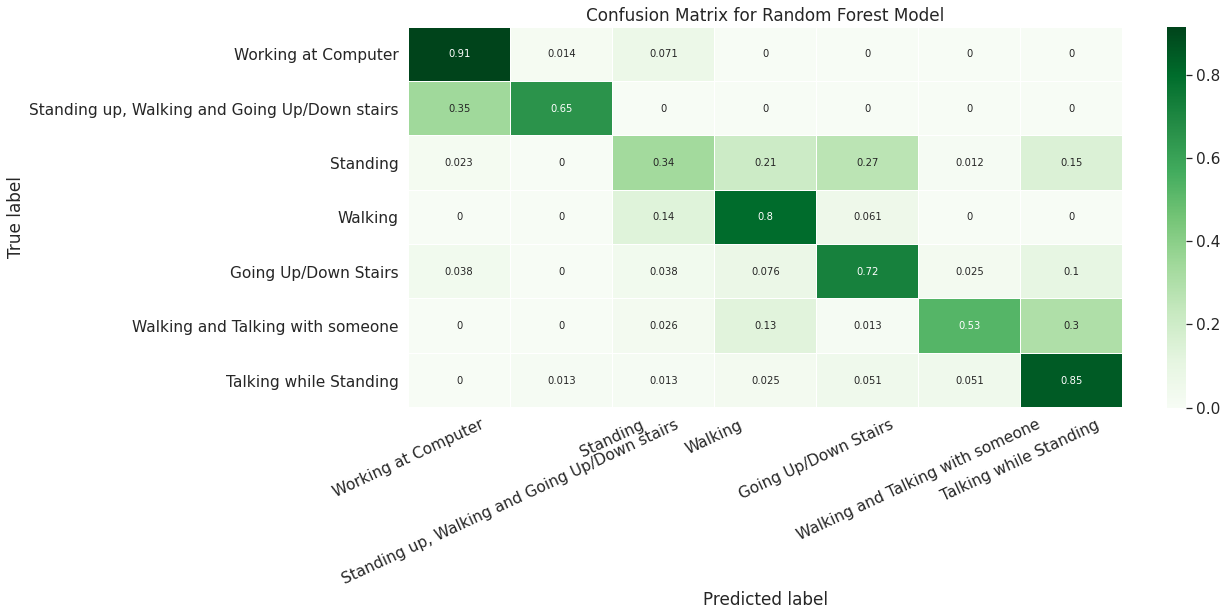

In [81]:
# Get and reshape confusion matrix data
matrix = confusion_matrix(y_test, y_pred_test)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['Working at Computer', 'Standing up, Walking and Going Up/Down stairs', 'Standing', 
               'Walking', 'Going Up/Down Stairs', 'Walking and Talking with someone',    
               'Talking while Standing']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()




In [82]:
sorted_idx = rfc.feature_importances_.argsort()
# plt.barh(X_columns[sorted_idx], rfc.feature_importances_[sorted_idx])
pd.DataFrame(rfc.feature_importances_[sorted_idx],index=X_columns[sorted_idx]).sort_values(by=0,ascending=False)




,0
rolling_T_minus_15_x_min,0.034277
rolling_T_minus_15_z_max,0.031395
rolling_z_Rstd,0.027626
rolling_z_Rmax,0.026915
rolling_T_minus_10_x_min,0.026286
rolling_T_minus_15_z_average,0.026006
rolling_T_minus_15_z_min,0.025087
rolling_T_minus_10_z_max,0.023544
rolling_x_Rmax,0.022414
rolling_T_minus_10_z_min,0.021944


In [36]:
X_columns

Index(['seq', 'x_acc', 'y_acc', 'z_acc', 'subject', 'x_acc_T_minus_1',
       'x_acc_T_minus_2', 'x_acc_T_minus_3', 'x_acc_T_minus_4',
       'x_acc_T_minus_5',
       ...
       'rolling_T_minus_10_z_min', 'rolling_T_minus_10_z_max',
       'rolling_T_minus_10_z_kurtosis', 'rolling_T_minus_10_z_skewness',
       'rolling_T_minus_15_z_average', 'rolling_T_minus_15_z_variance',
       'rolling_T_minus_15_z_min', 'rolling_T_minus_15_z_max',
       'rolling_T_minus_15_z_kurtosis', 'rolling_T_minus_15_z_skewness'],
      dtype='object', length=116)

In [69]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

X_columns

Index(['seq', 'x_acc', 'y_acc', 'z_acc', 'subject', 'x_acc_T_minus_1',
       'x_acc_T_minus_2', 'x_acc_T_minus_3', 'x_acc_T_minus_4',
       'x_acc_T_minus_5',
       ...
       'rolling_T_minus_10_z_min', 'rolling_T_minus_10_z_max',
       'rolling_T_minus_10_z_kurtosis', 'rolling_T_minus_10_z_skewness',
       'rolling_T_minus_15_z_average', 'rolling_T_minus_15_z_variance',
       'rolling_T_minus_15_z_min', 'rolling_T_minus_15_z_max',
       'rolling_T_minus_15_z_kurtosis', 'rolling_T_minus_15_z_skewness'],
      dtype='object', length=116)

In [45]:
####Generalized approach#####
def train_test_split(X, y, test_subject_id):
    '''
    Creates a train test split based on a subject id. The training data will
    not include any observations from the test subject in an effort to exlude
    any "behavioral" data leakage.
    Note that X must have a column named 'subject' in order to define the
    split, however the matrices that are returned will exlude the subject
    column.
    Parameters:
    ----------
    X : (Pandas DataFrame)
        A data frame that has a column named 'subject' that contains the
        subject id of each observations.
    y : (Pandas DataFrame - array-like)
        An array-like object that holds the target variable.
    test_subject_id : (int)
        The id of the subject to use as the test data.
        
    Returns:
    ----------
    x_train : (numpy.ndarray)
        The X matrix for training.
    x_test : (numpy.ndarray)
        The y vector for training.
    y_train : (numpy.ndarray)
        The X matrix for testing.
    y_test : (numpy.ndarray)
        The y vector for testing
    '''
    indices = X['subject'] == test_subject_id

    x_test = X.loc[indices, X.columns[~X.columns.isin(['subject'])]].values
    y_test = y[indices].values
    
    x_train = X.loc[~indices, X.columns[~X.columns.isin(['subject'])]].values
    y_train = y[~indices].values

    return x_train, x_test, y_train, y_test

def CV_multiple_models(X, y, model_dict, cv=8, verbose=True):
    '''
    Cross validates various models in model_dict using X and y.
    Parameters:
    ----------
    X : (Pandas DataFrame)
        A data frame that has a column named 'subject' that contains the
        subject id of each observations.
    y : (Pandas DataFrame - array-like)
        An array-like object that holds the target variable.
    model_dict : (dict)
        A dictionary of dictionaries. The keys of the model_dict should be the
        name of the model framework (i.e. 'Random Forest', 'SVM', etc.). The
        values should be another dict, with a key named 'Model' whose value
        is the model that has a fit() and predict() method.
    cv : (int)
        Analogous to the number of "folds" to make in K-Fold CV, although the
        method used in this function isn't exactly the same.
    verbose : (bool)
        Whether the testing set accuracy should be printed.
        
    Returns:
    ----------
    model_dict : (dict)
        The same model_dict that was used as an argument, however the inner
        dictionary will have a new key value pair of the cross validation
        scores (key = 'CV Scores').
    '''
    # randomly selecting subjects to use as testing subjects - doing this
    # within the function ensures that the ith element in
    # model_sub_dict['CV Scores'] is using the same testing subject for each
    # model.
    subjects_to_test = random.choices(np.unique(X['subject']), k=cv) 

    for model_name, model_sub_dict in model_dict.items():

        model_sub_dict['CV Scores'] = []

    for test_subject in subjects_to_test:

        x_train, x_test, y_train, y_test = train_test_split(X,
                                                            y,
                                                            test_subject)

        # undersample majority classes of training data randomly
        # Note that this leaves the target distribution of the test subject
        # intact.
        under_sampler = RandomUnderSampler(sampling_strategy='not minority',
                                           random_state=5,
                                           replacement=False)

        x_train, y_train = under_sampler.fit_resample(x_train, y_train)

        for model_name, model_sub_dict in model_dict.items():

            if verbose:
                print(f"Time = {time.ctime()} | Training a {model_name} on X and y")

            model_sub_dict['ModelPipeline'].fit(x_train,
                                                np.ravel(y_train))
            y_hat = model_sub_dict['ModelPipeline'].predict(x_test)

            acc = np.mean(y_hat == y_test)

            model_sub_dict['CV Scores'].append(acc)

            if verbose:
                print(f"Time = {time.ctime()} | {model_name} Accuracy = {acc}")

    # converting CV scores from list to np.array
    for _, model_sub_dict in model_dict.items():

        model_sub_dict['CV Scores'] = np.array(model_sub_dict['CV Scores'])

    return model_dict

Time = Mon Jan  3 22:13:01 2022 | Training a Random Forest on X and y


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 80 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 290 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   36.8s finished
[Parallel(n_jobs=80)]: Using backend ThreadingBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  40 tasks      | elapsed:    0.2s
[Parallel(n_jobs=80)]: Done 290 tasks      | elapsed:    0.9s
[Parallel(n_jobs=80)]: Done 500 out of 500 | elapsed:    1.3s finished


Time = Mon Jan  3 22:13:41 2022 | Random Forest Accuracy = 0.2304966218349435
Time = Mon Jan  3 22:13:41 2022 | Training a XGBoost Classifier on X and y


/home/debajeet/anaconda2/envs/seisml/lib/python3.6/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:13:45] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Time = Mon Jan  3 22:26:01 2022 | XGBoost Classifier Accuracy = 0.3077839868661994
Time = Mon Jan  3 22:26:01 2022 | Training a Multinomial Logistic Regression on X and y


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 80 concurrent workers.


max_iter reached after 227 seconds


/home/debajeet/anaconda2/envs/seisml/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


max_iter reached after 228 seconds
max_iter reached after 229 seconds
max_iter reached after 233 seconds
max_iter reached after 234 seconds
max_iter reached after 235 seconds
max_iter reached after 256 seconds
Time = Mon Jan  3 22:30:21 2022 | Multinomial Logistic Regression Accuracy = 0.26122371661299487


[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:  4.3min finished


Time = Mon Jan  3 22:30:29 2022 | Training a Random Forest on X and y


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 80 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 290 tasks      | elapsed:   24.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   37.4s finished
[Parallel(n_jobs=80)]: Using backend ThreadingBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  40 tasks      | elapsed:    0.3s
[Parallel(n_jobs=80)]: Done 290 tasks      | elapsed:    1.0s
[Parallel(n_jobs=80)]: Done 500 out of 500 | elapsed:    1.5s finished


Time = Mon Jan  3 22:31:10 2022 | Random Forest Accuracy = 0.5551139989557348
Time = Mon Jan  3 22:31:10 2022 | Training a XGBoost Classifier on X and y


/home/debajeet/anaconda2/envs/seisml/lib/python3.6/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:31:14] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Time = Mon Jan  3 22:43:40 2022 | XGBoost Classifier Accuracy = 0.5519884550675872
Time = Mon Jan  3 22:43:40 2022 | Training a Multinomial Logistic Regression on X and y


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 80 concurrent workers.


max_iter reached after 228 seconds


/home/debajeet/anaconda2/envs/seisml/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


max_iter reached after 229 seconds
max_iter reached after 230 seconds
max_iter reached after 231 seconds
max_iter reached after 232 seconds
max_iter reached after 233 seconds
max_iter reached after 239 seconds


[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:  4.0min finished


Time = Mon Jan  3 22:47:41 2022 | Multinomial Logistic Regression Accuracy = 0.19408829842780065
Time = Mon Jan  3 22:47:51 2022 | Training a Random Forest on X and y


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 80 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 290 tasks      | elapsed:   28.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   44.3s finished
[Parallel(n_jobs=80)]: Using backend ThreadingBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  40 tasks      | elapsed:    0.2s
[Parallel(n_jobs=80)]: Done 290 tasks      | elapsed:    0.7s
[Parallel(n_jobs=80)]: Done 500 out of 500 | elapsed:    1.1s finished


Time = Mon Jan  3 22:48:38 2022 | Random Forest Accuracy = 0.35530830122860485
Time = Mon Jan  3 22:48:38 2022 | Training a XGBoost Classifier on X and y


/home/debajeet/anaconda2/envs/seisml/lib/python3.6/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:48:42] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Time = Mon Jan  3 23:02:34 2022 | XGBoost Classifier Accuracy = 0.32098020048684184
Time = Mon Jan  3 23:02:34 2022 | Training a Multinomial Logistic Regression on X and y


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 80 concurrent workers.


max_iter reached after 267 seconds


/home/debajeet/anaconda2/envs/seisml/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


max_iter reached after 267 seconds
max_iter reached after 268 seconds
max_iter reached after 274 seconds
max_iter reached after 277 seconds
max_iter reached after 278 seconds
max_iter reached after 284 seconds


[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:  4.8min finished


Time = Mon Jan  3 23:07:21 2022 | Multinomial Logistic Regression Accuracy = 0.5188411630536868
Time = Mon Jan  3 23:07:31 2022 | Training a Random Forest on X and y


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 80 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 290 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   40.2s finished
[Parallel(n_jobs=80)]: Using backend ThreadingBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  40 tasks      | elapsed:    0.3s
[Parallel(n_jobs=80)]: Done 290 tasks      | elapsed:    0.8s
[Parallel(n_jobs=80)]: Done 500 out of 500 | elapsed:    1.1s finished


Time = Mon Jan  3 23:08:14 2022 | Random Forest Accuracy = 0.47582065026018233
Time = Mon Jan  3 23:08:14 2022 | Training a XGBoost Classifier on X and y


/home/debajeet/anaconda2/envs/seisml/lib/python3.6/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:08:18] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Time = Mon Jan  3 23:21:10 2022 | XGBoost Classifier Accuracy = 0.5102410109941703
Time = Mon Jan  3 23:21:10 2022 | Training a Multinomial Logistic Regression on X and y


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 80 concurrent workers.


max_iter reached after 241 seconds


/home/debajeet/anaconda2/envs/seisml/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


max_iter reached after 267 seconds
max_iter reached after 271 seconds
max_iter reached after 274 seconds
max_iter reached after 281 seconds
max_iter reached after 304 seconds
max_iter reached after 328 seconds


[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:  5.5min finished


Time = Mon Jan  3 23:26:40 2022 | Multinomial Logistic Regression Accuracy = 0.34903556477170466
Time = Mon Jan  3 23:26:49 2022 | Training a Random Forest on X and y


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 80 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 290 tasks      | elapsed:   25.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   40.0s finished
[Parallel(n_jobs=80)]: Using backend ThreadingBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  40 tasks      | elapsed:    0.3s
[Parallel(n_jobs=80)]: Done 290 tasks      | elapsed:    1.0s
[Parallel(n_jobs=80)]: Done 500 out of 500 | elapsed:    1.6s finished


Time = Mon Jan  3 23:27:33 2022 | Random Forest Accuracy = 0.2771801671086206
Time = Mon Jan  3 23:27:33 2022 | Training a XGBoost Classifier on X and y


/home/debajeet/anaconda2/envs/seisml/lib/python3.6/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:27:37] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Time = Mon Jan  3 23:40:38 2022 | XGBoost Classifier Accuracy = 0.30442287486866465
Time = Mon Jan  3 23:40:38 2022 | Training a Multinomial Logistic Regression on X and y


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 80 concurrent workers.


max_iter reached after 244 seconds


/home/debajeet/anaconda2/envs/seisml/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


max_iter reached after 245 seconds
max_iter reached after 251 seconds
max_iter reached after 259 seconds
max_iter reached after 266 seconds
max_iter reached after 296 seconds
max_iter reached after 321 seconds


[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:  5.4min finished


Time = Mon Jan  3 23:46:01 2022 | Multinomial Logistic Regression Accuracy = 0.3394018612097864
Time = Mon Jan  3 23:46:10 2022 | Training a Random Forest on X and y


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 80 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 290 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   38.9s finished
[Parallel(n_jobs=80)]: Using backend ThreadingBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  40 tasks      | elapsed:    0.2s
[Parallel(n_jobs=80)]: Done 290 tasks      | elapsed:    0.8s
[Parallel(n_jobs=80)]: Done 500 out of 500 | elapsed:    1.3s finished


Time = Mon Jan  3 23:46:52 2022 | Random Forest Accuracy = 0.205038579799269
Time = Mon Jan  3 23:46:52 2022 | Training a XGBoost Classifier on X and y


/home/debajeet/anaconda2/envs/seisml/lib/python3.6/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:46:55] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Time = Mon Jan  3 23:59:52 2022 | XGBoost Classifier Accuracy = 0.17204269884550677
Time = Mon Jan  3 23:59:52 2022 | Training a Multinomial Logistic Regression on X and y


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 80 concurrent workers.


max_iter reached after 241 seconds


/home/debajeet/anaconda2/envs/seisml/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


max_iter reached after 242 seconds
max_iter reached after 242 seconds
max_iter reached after 246 seconds
max_iter reached after 261 seconds
max_iter reached after 268 seconds
max_iter reached after 287 seconds


[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:  4.8min finished


Time = Tue Jan  4 00:04:42 2022 | Multinomial Logistic Regression Accuracy = 0.4266258629691942
Time = Tue Jan  4 00:04:51 2022 | Training a Random Forest on X and y


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 80 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 290 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   40.3s finished
[Parallel(n_jobs=80)]: Using backend ThreadingBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  40 tasks      | elapsed:    0.2s
[Parallel(n_jobs=80)]: Done 290 tasks      | elapsed:    0.7s
[Parallel(n_jobs=80)]: Done 500 out of 500 | elapsed:    1.0s finished


Time = Tue Jan  4 00:05:35 2022 | Random Forest Accuracy = 0.47582065026018233
Time = Tue Jan  4 00:05:35 2022 | Training a XGBoost Classifier on X and y


/home/debajeet/anaconda2/envs/seisml/lib/python3.6/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:05:38] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Time = Tue Jan  4 00:18:31 2022 | XGBoost Classifier Accuracy = 0.5102410109941703
Time = Tue Jan  4 00:18:31 2022 | Training a Multinomial Logistic Regression on X and y


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 80 concurrent workers.


max_iter reached after 242 seconds


/home/debajeet/anaconda2/envs/seisml/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


max_iter reached after 244 seconds
max_iter reached after 246 seconds
max_iter reached after 246 seconds
max_iter reached after 250 seconds
max_iter reached after 256 seconds
max_iter reached after 259 seconds


[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:  4.3min finished


Time = Tue Jan  4 00:22:52 2022 | Multinomial Logistic Regression Accuracy = 0.3490453460620525
Time = Tue Jan  4 00:23:03 2022 | Training a Random Forest on X and y


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 80 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 290 tasks      | elapsed:   25.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   40.2s finished
[Parallel(n_jobs=80)]: Using backend ThreadingBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  40 tasks      | elapsed:    0.2s
[Parallel(n_jobs=80)]: Done 290 tasks      | elapsed:    0.7s
[Parallel(n_jobs=80)]: Done 500 out of 500 | elapsed:    1.0s finished


Time = Tue Jan  4 00:23:47 2022 | Random Forest Accuracy = 0.4139521838368989
Time = Tue Jan  4 00:23:47 2022 | Training a XGBoost Classifier on X and y


/home/debajeet/anaconda2/envs/seisml/lib/python3.6/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:23:51] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Time = Tue Jan  4 00:37:01 2022 | XGBoost Classifier Accuracy = 0.41454214863244226
Time = Tue Jan  4 00:37:01 2022 | Training a Multinomial Logistic Regression on X and y


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 80 concurrent workers.


max_iter reached after 246 seconds


/home/debajeet/anaconda2/envs/seisml/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


max_iter reached after 246 seconds
max_iter reached after 251 seconds
max_iter reached after 252 seconds
max_iter reached after 269 seconds
max_iter reached after 285 seconds
max_iter reached after 290 seconds
Time = Tue Jan  4 00:41:53 2022 | Multinomial Logistic Regression Accuracy = 0.2364985105806801


[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:  4.8min finished


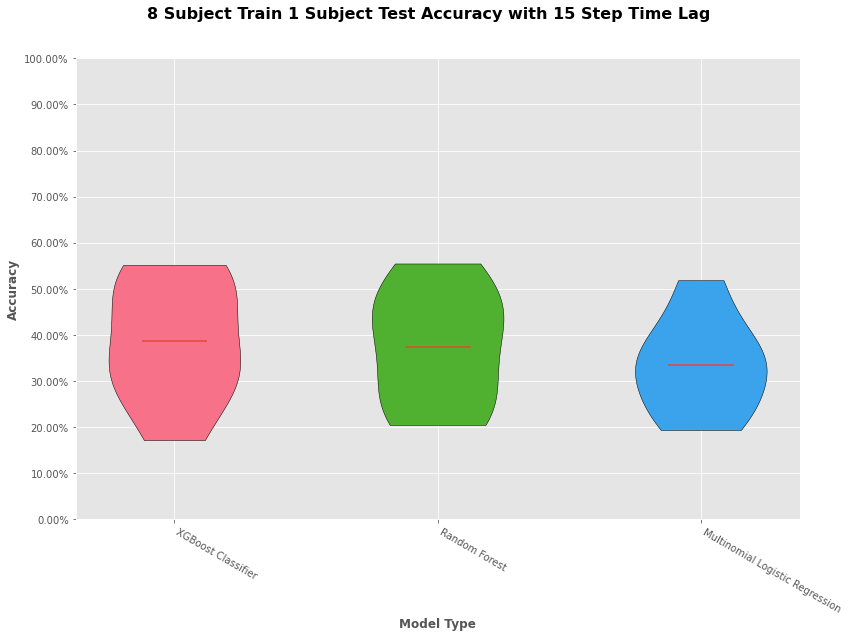

In [54]:
X_columns = lag_15_df.columns[~lag_15_df.columns.isin(['label','seq'])]

lag_15_X = lag_15_df[X_columns]
lag_15_y = lag_15_df['label']
import random
from collections import Counter
model_dict = CV_multiple_models(X=lag_15_X,
                                y=lag_15_y,
                                model_dict=model_dict)


cv_error_dict = {}
for name, sub_dict in model_dict.items():
    cv_error_dict[name] = sub_dict['CV Scores']

filename="error_generalized_plot.tiff"
cv_error_comparison_plot(pd.DataFrame(cv_error_dict),
                         x_label="Model Type",
                         y_label="Accuracy",
                         title=f'8 Subject Train 1 Subject Test Accuracy with 15 Step Time Lag',
                         filename=filename)

In [52]:
X_columns = lag_15_df.columns[~lag_15_df.columns.isin(['label','seq'])]

lag_15_X = lag_15_df[X_columns]
lag_15_y = lag_15_df['label']

In [57]:
lag_15_y

15        1
16        1
17        1
18        1
19        1
         ..
166736    7
166737    7
166738    7
166739    7
166740    7
Name: label, Length: 1925321, dtype: object